In [1]:
from IPython.core.display import display, HTML

display(HTML("<style>.container { width:70% !important; }</style>"))

This project aims to predict a user will skip or not a given track on Spotify.

## Import Libs

In [4]:
import pandas as pd
import numpy as np
import gc
import seaborn as sns
import matplotlib.pyplot as plt
import shap
import datetime

from xgboost.sklearn import XGBClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from pandas_profiling import ProfileReport
from helper import *

from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)

## Read Datas

In [5]:
df = pd.read_csv("./data/log_mini.csv")
dff = pd.read_csv("./data/tf_mini.csv")

## PandasProfile Report

In [6]:
# profile_session = ProfileReport(df, title="Session Report")

# profile_session.to_file("session_report.html")

# profile_track = ProfileReport(dff, title="Track Report")

# profile_track.to_file("track_report.html")

## Session

<strong>Listening Session Logs Dataset - Schema</strong>

|Field|Values|
|-----|------|
|session_id| E.g. ​65_283174c5-551c-4c1b-954b-cb60ffcc2aec- unique identifier for the session that this row is a part of|
|session_position| {1-20} - position of row within session|
|session_length| {10-20} - number of rows in session
|track_id_clean|E.g. ​t_13d34e4b-dc9b-4535-963d-419afa8332ec - unique identifier for the track played. This is linked with track_id in the track features and metadata table.|
|skip_1| Boolean indicating if the track was only played very briefly|
|skip_2|Boolean indicating if the track was only played briefly|
|skip_3| Boolean indicating if most of the track was played|
|not_skipped| Boolean indicating that the track was played in its entirety|
|context_switch| Boolean indicating if the user changed context between the previous row and the current row. This could for example occur if the user switched from one playlist to another.|
|no_pause_before_play|Boolean indicating if there was no pause between playback of the previous track and this track|
|short_pause_before_play| Boolean indicating if there was a short pause between playback of the previous track and this track|
|long_pause_before_play| Boolean indicating if there was a long pause between playback of the previous track and this track|
|hist_user_behavior_n_seekfwd| Number of times the user did a seek forward within track|
|hist_user_behavior_n_seekback| Number of times the user did a seek back within track|
|hist_user_behavior_is_shuffle| Boolean indicating if the user encountered this track while shuffle mode was activated
|hour_of_day| {0-23} - The hour of day
|date| E.g. 2018-09-18 - The date|
|premium| Boolean indicating if the user was on premium or not. This has potential implications for skipping behavior.|
|context_type| E.g. ​editorial playlist - ​what type of context the playback occurred within|
|hist_user_behavior_reason_start| E.g. ​fwdbtn​ - the user action which led to the current track being played|
|hist_user_behavior_reason_end| E.g. ​trackdone​ - the user action which led to the current track playback ending|

In [7]:
df.head()

df.shape

,session_id,session_position,session_length,track_id_clean,skip_1,skip_2,skip_3,not_skipped,context_switch,no_pause_before_play,short_pause_before_play,long_pause_before_play,hist_user_behavior_n_seekfwd,hist_user_behavior_n_seekback,hist_user_behavior_is_shuffle,hour_of_day,date,premium,context_type,hist_user_behavior_reason_start,hist_user_behavior_reason_end
0,0_00006f66-33e5-4de7-a324-2d18e439fc1e,1,20,t_0479f24c-27d2-46d6-a00c-7ec928f2b539,False,False,False,True,0,0,0,0,0,0,True,16,2018-07-15,True,editorial_playlist,trackdone,trackdone
1,0_00006f66-33e5-4de7-a324-2d18e439fc1e,2,20,t_9099cd7b-c238-47b7-9381-f23f2c1d1043,False,False,False,True,0,1,0,0,0,0,True,16,2018-07-15,True,editorial_playlist,trackdone,trackdone
2,0_00006f66-33e5-4de7-a324-2d18e439fc1e,3,20,t_fc5df5ba-5396-49a7-8b29-35d0d28249e0,False,False,False,True,0,1,0,0,0,0,True,16,2018-07-15,True,editorial_playlist,trackdone,trackdone
3,0_00006f66-33e5-4de7-a324-2d18e439fc1e,4,20,t_23cff8d6-d874-4b20-83dc-94e450e8aa20,False,False,False,True,0,1,0,0,0,0,True,16,2018-07-15,True,editorial_playlist,trackdone,trackdone
4,0_00006f66-33e5-4de7-a324-2d18e439fc1e,5,20,t_64f3743c-f624-46bb-a579-0f3f9a07a123,False,False,False,True,0,1,0,0,0,0,True,16,2018-07-15,True,editorial_playlist,trackdone,trackdone


(167880, 21)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167880 entries, 0 to 167879
Data columns (total 21 columns):
 #   Column                           Non-Null Count   Dtype 
---  ------                           --------------   ----- 
 0   session_id                       167880 non-null  object
 1   session_position                 167880 non-null  int64 
 2   session_length                   167880 non-null  int64 
 3   track_id_clean                   167880 non-null  object
 4   skip_1                           167880 non-null  bool  
 5   skip_2                           167880 non-null  bool  
 6   skip_3                           167880 non-null  bool  
 7   not_skipped                      167880 non-null  bool  
 8   context_switch                   167880 non-null  int64 
 9   no_pause_before_play             167880 non-null  int64 
 10  short_pause_before_play          167880 non-null  int64 
 11  long_pause_before_play           167880 non-null  int64 
 12  hist_user_behavi

In [9]:
print(f"Duplicate values: {df.duplicated().sum().sum()}")

Duplicate values: 0


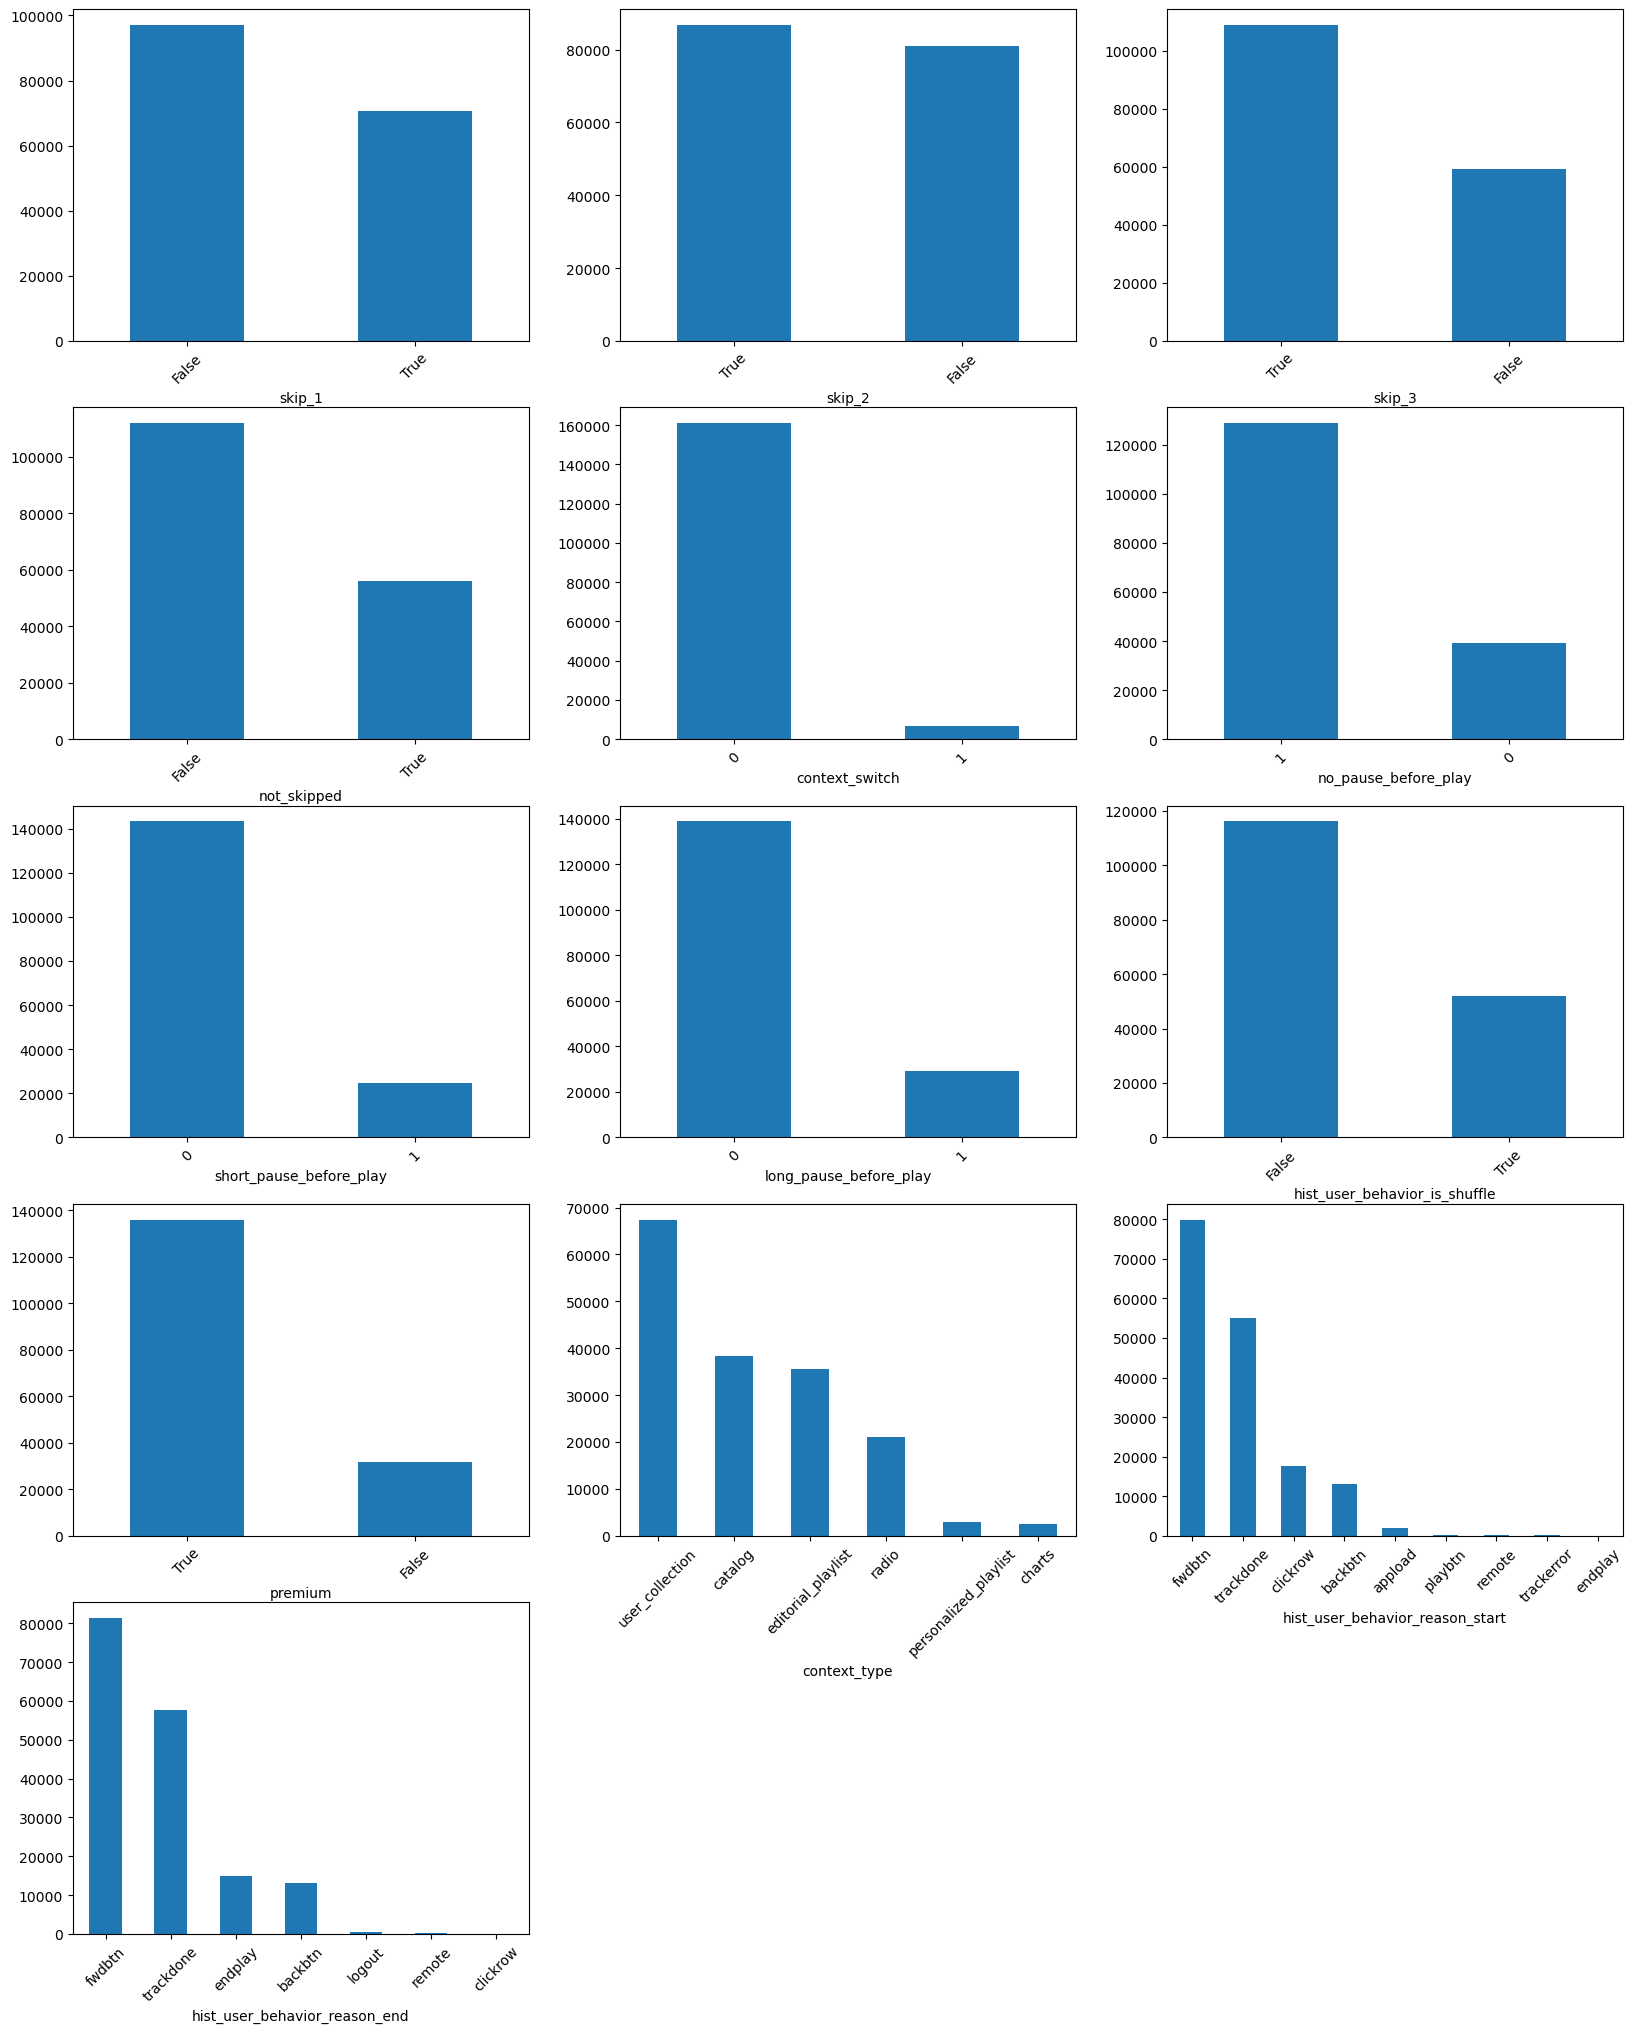

In [10]:
bool_obj_col = [
    'skip_1', 'skip_2', 'skip_3', 'not_skipped', 'context_switch',
    'no_pause_before_play', 'short_pause_before_play',
    'long_pause_before_play', 'hist_user_behavior_is_shuffle', 'premium',
    'context_type', 'hist_user_behavior_reason_start',
    'hist_user_behavior_reason_end'
]


# bool_obj_col = df.select_dtypes(exclude="number")

plt.figure(figsize=(20,25))
n = 1

for colname in bool_obj_col:
    plt.subplot(5,3,n)
    df[colname].value_counts().plot(kind='bar')
    plt.xlabel(colname)
    plt.xticks(rotation=45)
    n +=1
    
plt.show();

In [11]:
df.nunique()

session_id                         10000
session_position                      20
session_length                        11
track_id_clean                     50704
skip_1                                 2
skip_2                                 2
skip_3                                 2
not_skipped                            2
context_switch                         2
no_pause_before_play                   2
short_pause_before_play                2
long_pause_before_play                 2
hist_user_behavior_n_seekfwd          25
hist_user_behavior_n_seekback         30
hist_user_behavior_is_shuffle          2
hour_of_day                           24
date                                  18
premium                                2
context_type                           6
hist_user_behavior_reason_start        9
hist_user_behavior_reason_end          7
dtype: int64

In [12]:
# How many listening sessions are there by premium Spotify users?
pd.DataFrame(
    df.drop_duplicates(subset=['session_id'])['premium'].value_counts())

,premium
True,8028
False,1972


In [13]:
df[["session_length"]].value_counts()

session_length
20                101320
11                  8272
10                  8190
12                  7752
13                  7111
15                  6525
14                  6426
19                  5966
18                  5454
17                  5440
16                  5424
dtype: int64

***

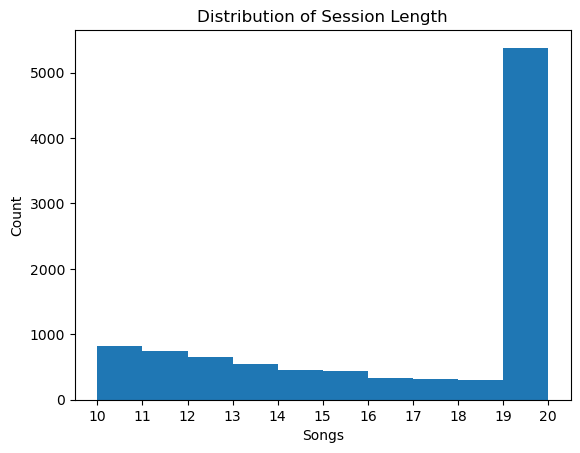

In [14]:
# Plots distribution of Listening Session Length
plt.figure()
df.drop_duplicates(subset=['session_id'])['session_length'].plot.hist()
plt.title('Distribution of Session Length')
plt.xlabel('Songs')
plt.ylabel('Count')
plt.xticks(range(10, 21, 1))
plt.show();

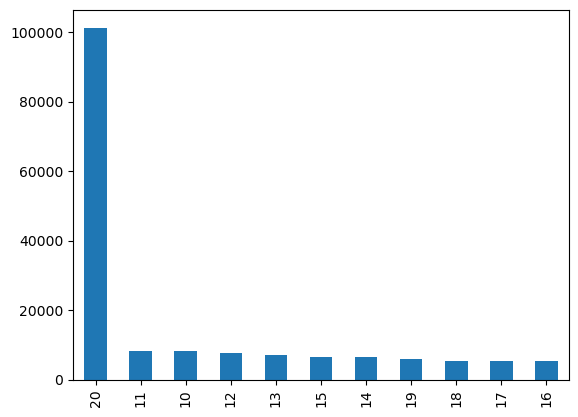

In [15]:
df.session_length.value_counts().plot(kind = 'bar');

The majority of listening sessions are 20 songs long. 

***

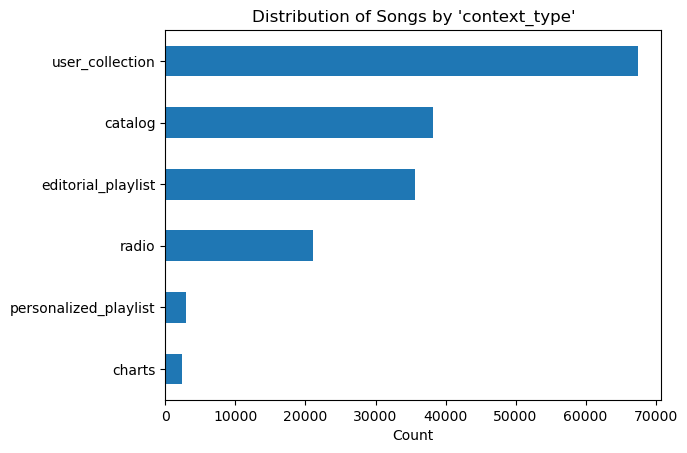

In [16]:
# Plots the distribution of songs by 'context_type'
plt.figure()
df['context_type'].value_counts().sort_values().plot.barh()
plt.title("Distribution of Songs by 'context_type'")
plt.xlabel('Count')
plt.show();

Most of the songs belong to a user collection of songs. Followed by the Spotify catalog and editorial playlists.

***

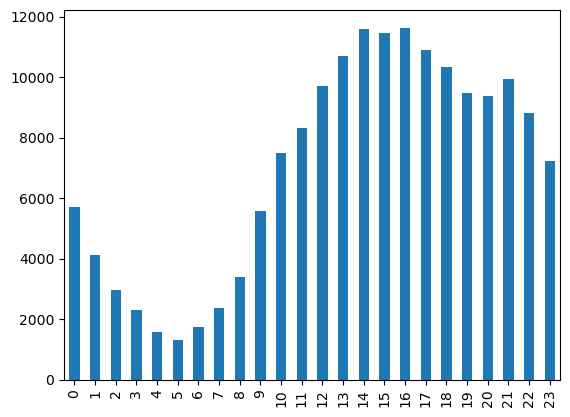

In [17]:
# Plots distribution of songs played by 'hour_of_day' - > what part of the day
plt.figure()
df['hour_of_day'].value_counts().sort_index().plot.bar()
plt.show();

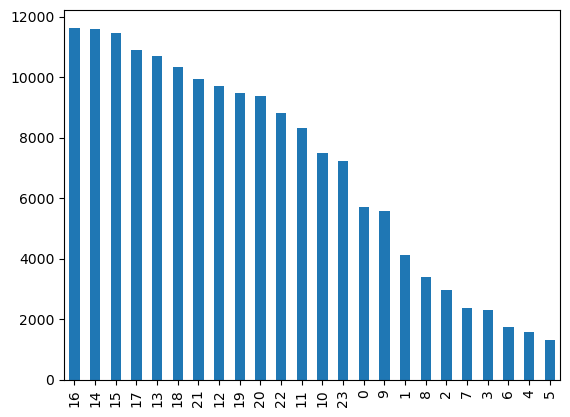

In [18]:
df.hour_of_day.value_counts().plot(kind="bar");

Listening activity appears to peak in the afternoon, then generally declines towards the 5am where listening activity is the lowest. Which would make sense as we'd expected users to be sleeping around that time. Then listening activity appears to increase. Users start using Spotify as they start their day.

***

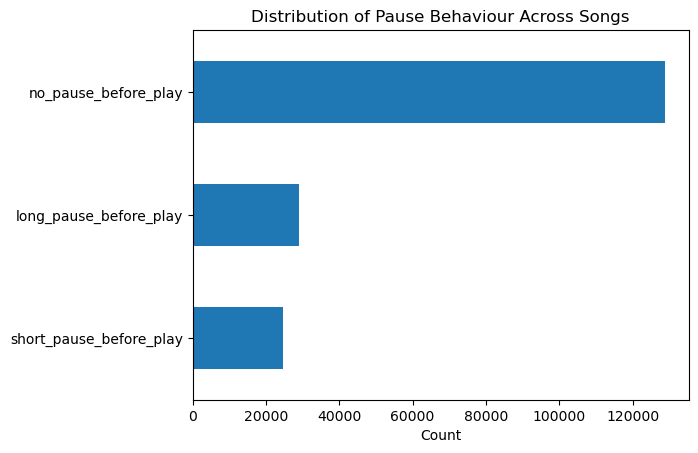

In [19]:
plt.figure()
df[[
    'no_pause_before_play', 'short_pause_before_play', 'long_pause_before_play'
]].sum().sort_values().plot.barh()
plt.title('Distribution of Pause Behaviour Across Songs')
plt.xlabel('Count')
plt.show();

Majority of songs are played without pause before. This would likely encourage songs to play continuously if possible.
***

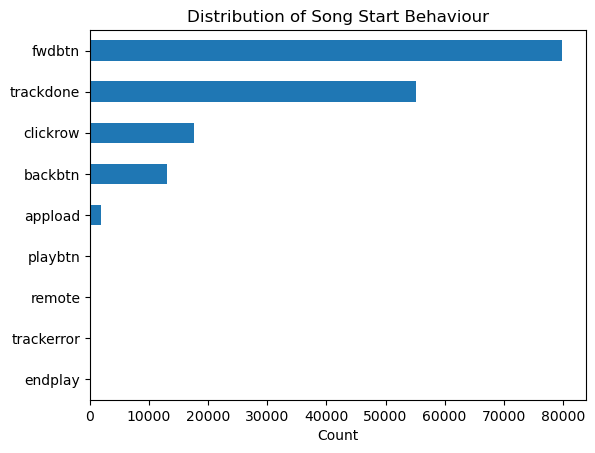

In [20]:
plt.figure()
df['hist_user_behavior_reason_start'].value_counts().sort_values().plot.barh()
plt.title('Distribution of Song Start Behaviour')
plt.xlabel('Count')
plt.show();

You can see that songs were started using the forward button more often then there were by having the previous track finish on its own. Which seems to suggest that users might have arrived at the current song with hopes that this is a better song than the previous one in which they had skipped
***

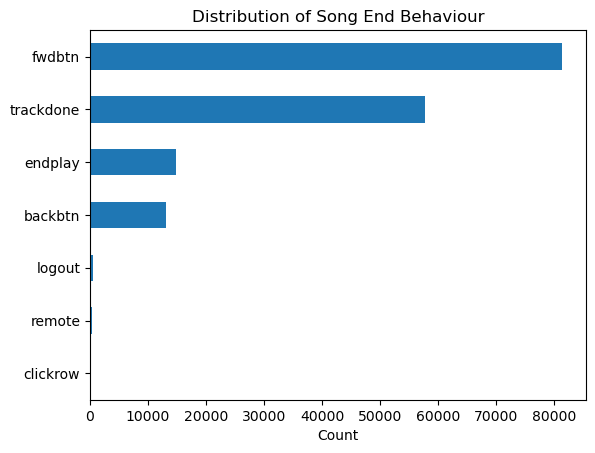

In [21]:
plt.figure()
df['hist_user_behavior_reason_end'].value_counts().sort_values().plot.barh()
plt.title('Distribution of Song End Behaviour')
plt.xlabel('Count')
plt.show();

This figure shows the other half in terms of listening experience. If a song starts, it must also end. In this we can see that more often, songs ended by the user pressing the forward button, rather than the song playing out until the end. It appears that there is a trend starting to emerge in the data. Users seem to be skipping songs more often than they are letting them play until the end.
***

Finally select the target columns. This dataset stratifies user skip behaviour by the time it takes for them to skip. In other words, how much of the song had the user played before deciding to skip?

|Field|Values|
|-----|------|
|skip_1| Boolean indicating if the track was only played very briefly|
|skip_2|Boolean indicating if the track was only played briefly|
|skip_3| Boolean indicating if most of the track was played|
|not_skipped| Boolean indicating that the track was played in its entirety|

In [22]:
# Gets the mean for each type of skip behaviour
pd.DataFrame(df[['skip_1', 'skip_2', 'skip_3', 'not_skipped']].mean(), columns=['mean'])

,mean
skip_1,0.42
skip_2,0.52
skip_3,0.65
not_skipped,0.33


In [23]:
df[["skip_1", "skip_2", "skip_3", "not_skipped"]].corr()

,skip_1,skip_2,skip_3,not_skipped
skip_1,1.00,0.82,0.63,-0.60
skip_2,0.82,1.00,0.76,-0.73
skip_3,0.63,0.76,1.00,-0.96
not_skipped,-0.60,-0.73,-0.96,1.00


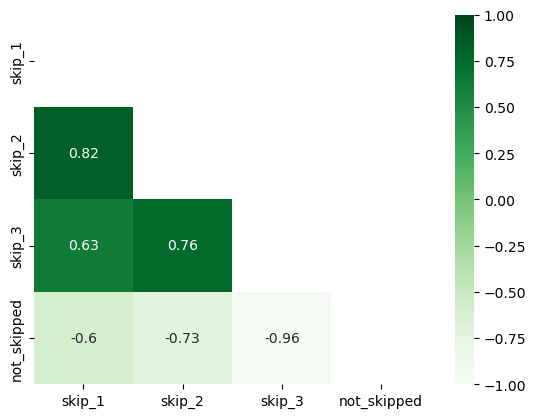

In [24]:
mask = np.triu(
    np.ones_like(df[["skip_1", "skip_2", "skip_3", "not_skipped"]].corr(),
                 dtype=np.bool))
heatmap = sns.heatmap(df[["skip_1", "skip_2", "skip_3", "not_skipped"]].corr(),
                      mask=mask,
                      vmin=-1,
                      vmax=1,
                      annot=True,
                      cmap='Greens')

In [25]:
# sns.heatmap(df[["skip_1" ,"skip_2", "skip_3", "not_skipped"]].corr(), annot=True, cmap="Greens"); BrBG

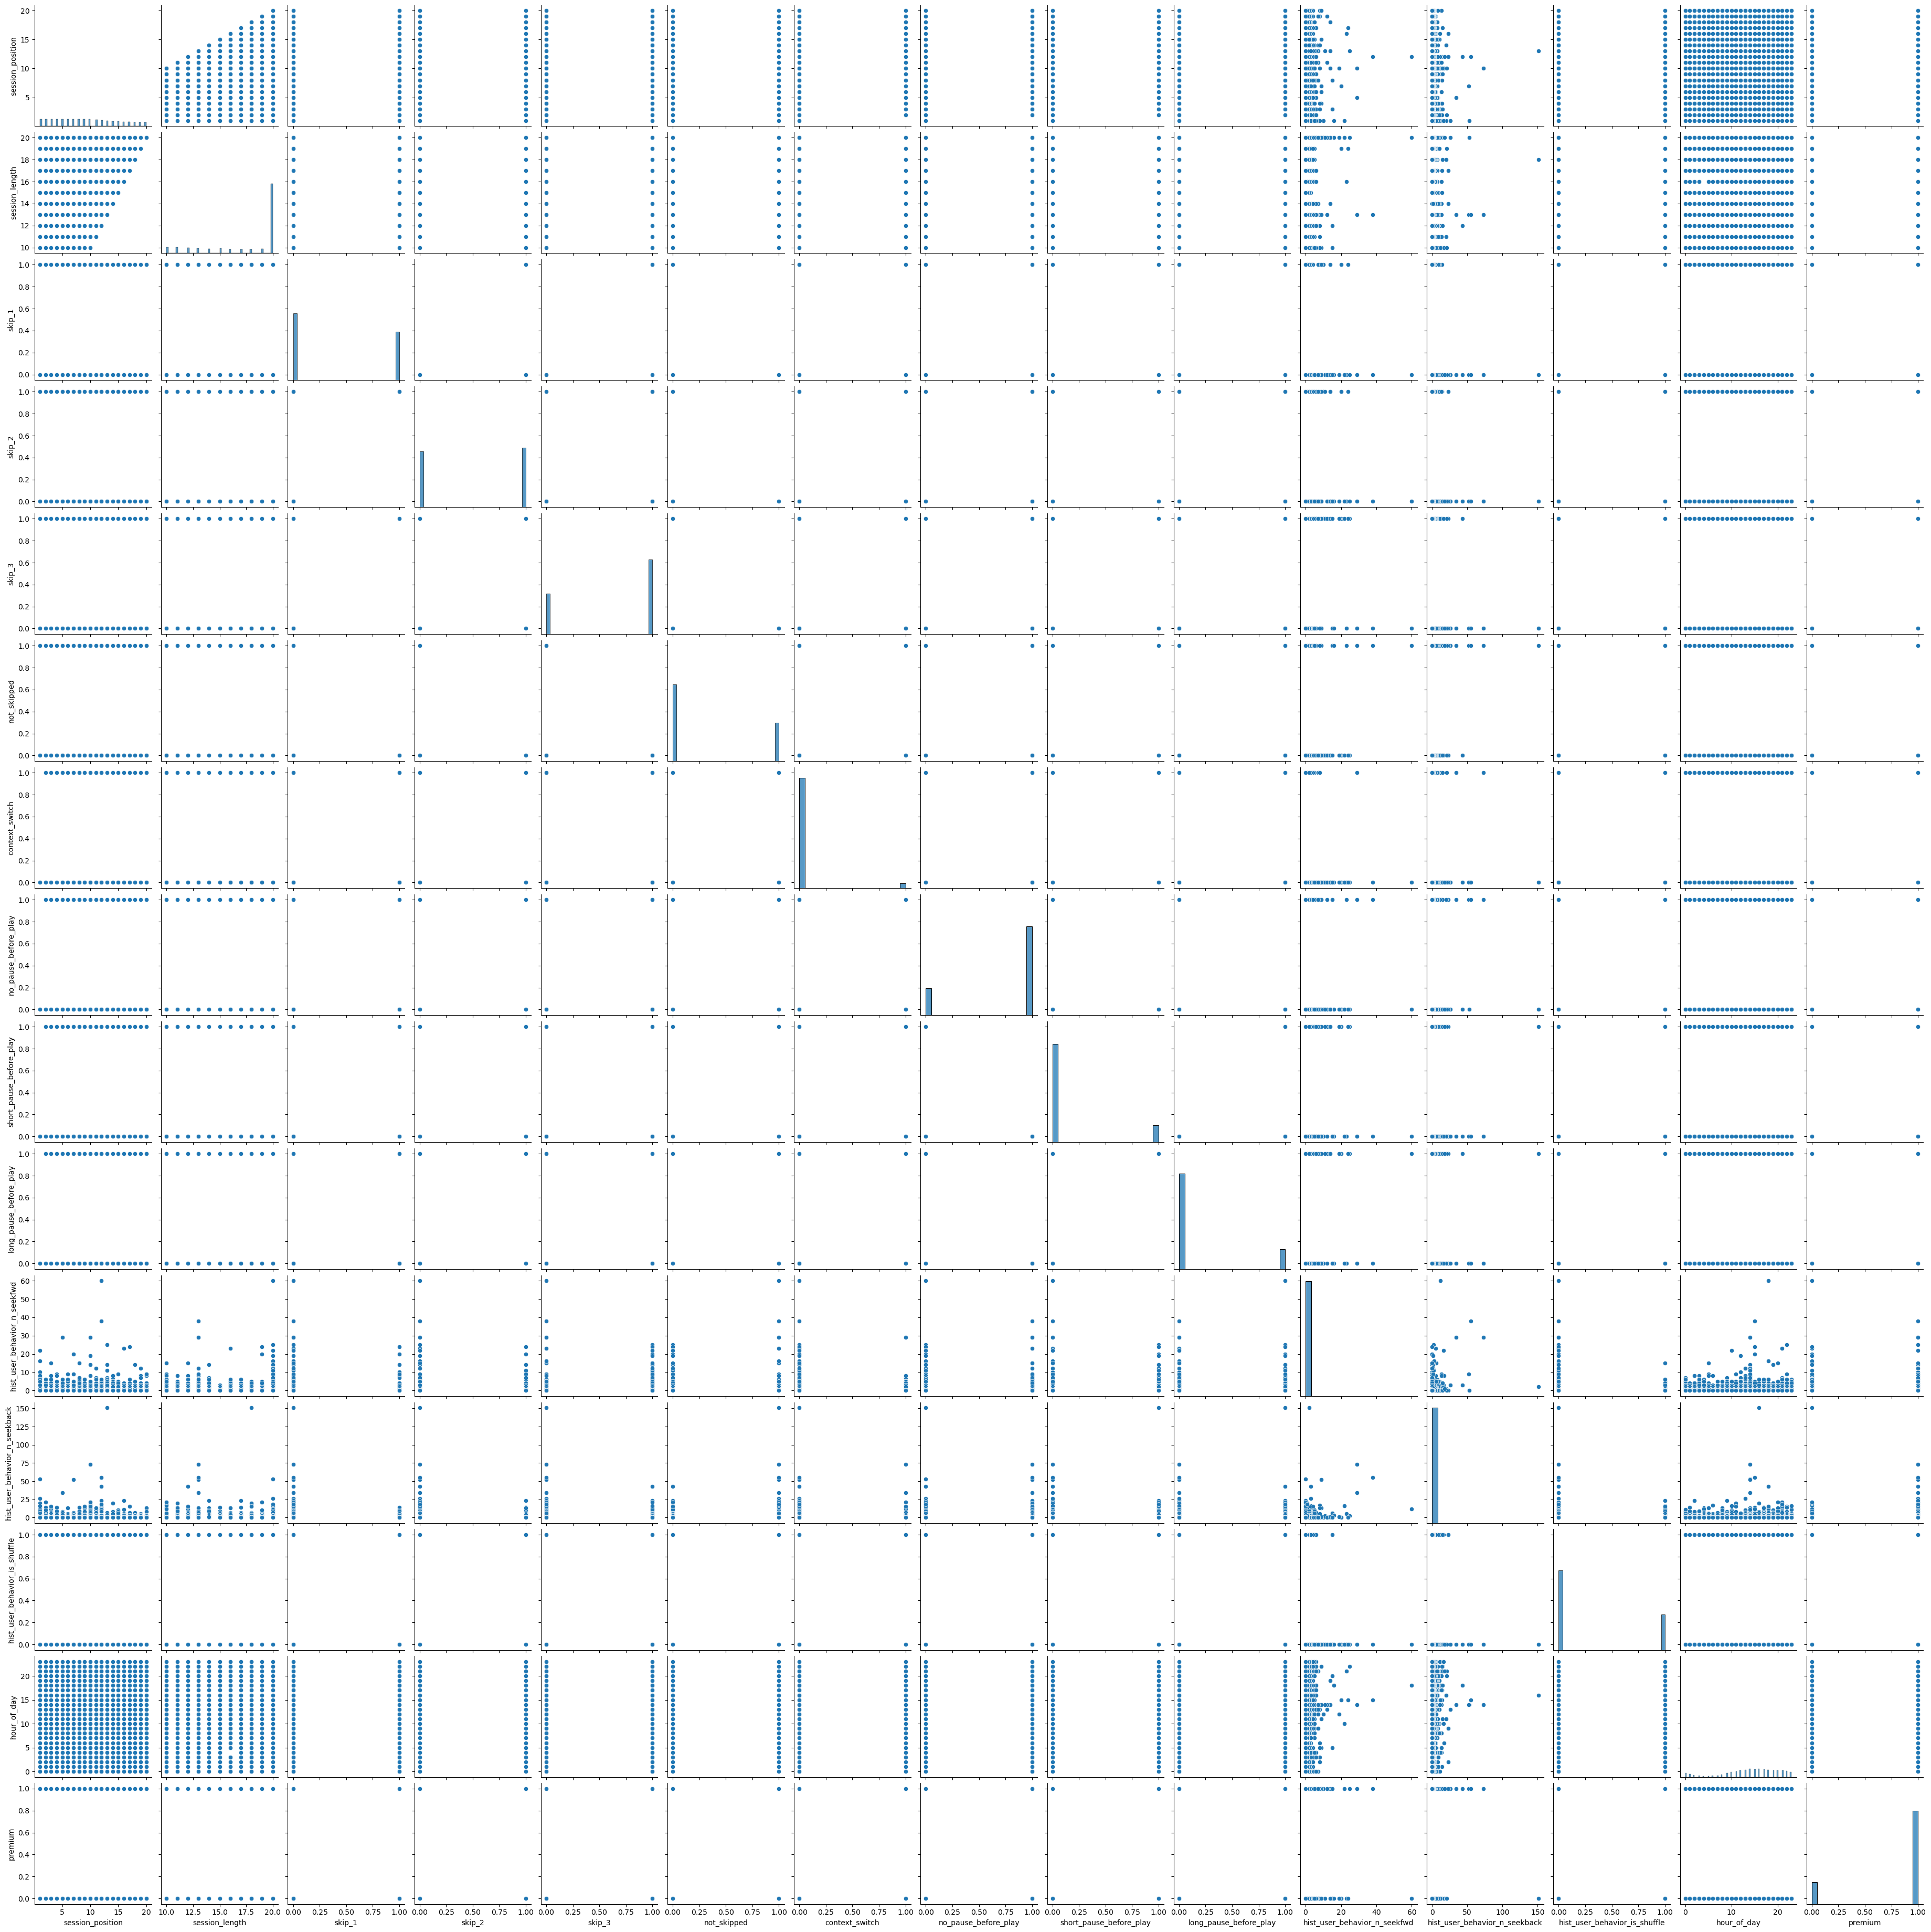

In [26]:
sns.pairplot(
    df.astype({
    "skip_1":"int32",
    "skip_2":"int32",
    "skip_3":"int32",
    "not_skipped":"int32",
    "hist_user_behavior_is_shuffle":"int32",
    "premium":"int32"
})
);
# plt.savefig("images/training_set_pairplot.png");

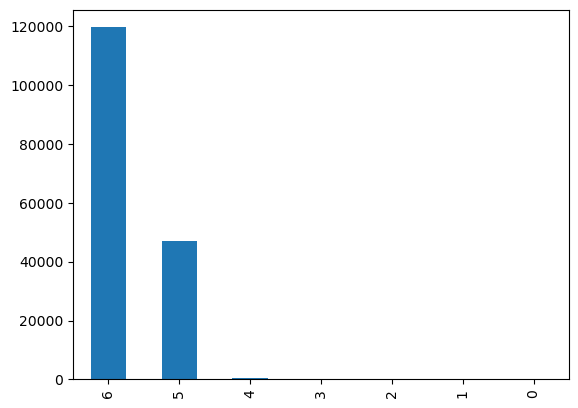

In [27]:
# Plot of distribution of data based on weekday
df.apply(
    lambda row: datetime.datetime.strptime(row.date, "%Y-%m-%d").weekday(),
    axis=1).value_counts().plot(kind='bar');

<div class="alert alert-block alert-info"> 
    <ul>
    <li>There is no missing and duplicate value.</li>
    <li>There are 167880 rows and 21 columns.</li>
    <li>There is varying magnitudes of scale across features.</li>
    <li>Choose the target that is skip_2 column. So dataset is not imbalance.&nbsp;</li>
    <li>Most of columns are number, some of boolean. Object-type columns are &quot;session_id&quot;, &quot;track_id_clean&quot; and &quot;date&quot; which related to the date of the session.</li>
    <li>Session_id and track_id_clean is unique as identifier.</li>
    <li>We know which song was played in which session. We have no way of figuring out what the name and artist of the song was.</li>
     <li>We can see that the song was skipped by the user.</li>
     <li>  We can see that the song was played on which date and what time</li>
     <li>It also shows how the user arrived at the current track and how the track ended. For example, they arrived at the song using the forward button, and the track ended using the forward button.</li>
    <li>Most of users have premium account 1:8</li>
    <li>Most listening sessions in the dataset were 20 songs in length.</li>
    <li>Users most often listened to songs in their own music collection, followed by the Spotify catalogue, then editorial playlists.</li>
    <li>Hour-of-day column appears to follow our typical sleep-wake pattern.</li>
    <li>Users did not typical pause before listening to the next song in the session. </li>
    <li>Users were more like to start and end a song using the forward button, rather than letting the track play through. </li>
    <li>Track&apos;s features are in <a href="https://developer.spotify.com/documentation/web-api/reference/#/operations/get-audio-features">https://developer.spotify.com/documentation/web-api/reference/#/operations/get-audio-features</a></li>
    
</ul>
</div>

## Track

<strong>Track Features Dataset - Schema</strong>

|Field|Values|
|-----|------|
|track_id|E.g. ​t_13d34e4b-dc9b-4535-963d-419afa8332ec - unique identifier for the track played. This is linked with track_id_clean in the session logs|
|duration|Length of track in seconds|
|release_year|Estimate of the year the track was released|
|us_popularity_estimate|Estimate of the US popularity percentile of the track as of October 12, 2018|
|acousticness|A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic. >= 0<= 1|
|beat_strength|\*This measure is undocumented. It ranges between 0 and 1. The audio feature likely describes the rhythmic and perceptual characteristics contributing to the perceived clarity of the beat in a track.|
|bounciness|\*This measure is undocumented. It ranges between 0 and 1. This audio feature is likely a compound measure based on perceptual and acoustical factors contributing to a sense of ‘bounce’ in the track, likely involving calculating attack slopes and general length of musical onsets.|
|danceability|Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable.|
|dyn_range_mean|This measure is not specified. It is a positive value and, in all likelihood, reflects the dynamic range in a track, given in decibels (dB). We assume this value measures the mean dynamic range in the track, as a measure of the range in amplitude within a given window of samples.|
|energy|Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy.|
|flatness|\*This measure is undocumented. It ranges between 0 and 1. This audio feature is likely a compound measure based on perceptual and acoustical factors contributing to a sense of ‘flatness' in the track, likely involving a low density of events and little auditory transients.|
|instrumentalness|Predicts whether a track contains no vocals. "Ooh" and "aah" sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly "vocal". The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content. Values above 0.5 are intended to represent instrumental tracks, but confidence is higher as the value approaches 1.0.|
|key|The key the track is in. Integers map to pitches using standard Pitch Class notation. E.g. 0 = C, 1 = C♯/D♭, 2 = D, and so on. If no key was detected, the value is -1. >= -1<= 11|
|loudness|The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values typically range between -60 and 0 db.|
|mechanism|\*This measure is undocumented. It ranges between 0 and 1. This audio feature is likely a compound measure of multiple perceptual features and other features, indicating if a track is perceived as ‘mechanic’, as opposed to the previously mentioned organism.|
|mode|Mode indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived. Major is represented by 1 and minor is 0.|
|organism|\*This measure is undocumented. It ranges between 0 and 1. This audio feature is likely a compound measure of multiple perceptual features and other audio features, indicating if a track is perceived as ‘organic’, in the sense that tempo and acousticness may exhibit a higher variability, dynamic range may be high.
|speechiness|Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks.|
|tempo|The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration.|
|time_signature|An estimated time signature. The time signature (meter) is a notational convention to specify how many beats are in each bar (or measure). The time signature ranges from 3 to 7 indicating time signatures of "3/4", to "7/4". >= 3<= 7|
|valence|A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry). >= 0<= 1|
|acoustic_vector_0|Spotify provides a 7-dimensional acoustic vector, representing each track. See ​http://benanne.github.io/2014/08/05/spotify-cnns.html​ and http://papers.nips.cc/paper/5004-deep-content-based|
|acoustic_vector_1|
|acoustic_vector_2|
|acoustic_vector_3|
|acoustic_vector_4|
|acoustic_vector_5|
|acoustic_vector_6|
|acoustic_vector_7|

Source: https://developer.spotify.com/documentation/web-api/reference/#/operations/get-audio-features

***

<!---
https://en.wikipedia.org/wiki/Pitch_class

from IPython.display import Image
Image(filename='output1.png')-->

![alt text](dff_key.png)

In [28]:
dff.head()
dff.shape

,track_id,duration,release_year,us_popularity_estimate,acousticness,beat_strength,bounciness,danceability,dyn_range_mean,energy,flatness,instrumentalness,key,liveness,loudness,mechanism,mode,organism,speechiness,tempo,time_signature,valence,acoustic_vector_0,acoustic_vector_1,acoustic_vector_2,acoustic_vector_3,acoustic_vector_4,acoustic_vector_5,acoustic_vector_6,acoustic_vector_7
0,t_a540e552-16d4-42f8-a185-232bd650ea7d,109.71,1950,99.98,0.46,0.52,0.50,0.40,7.51,0.82,0.90,0.00,0,0.13,-11.24,0.39,major,0.54,0.08,166.29,4,0.94,-0.03,-0.41,-0.03,0.35,0.83,-0.21,-0.30,-0.68
1,t_67965da0-132b-4b1e-8a69-0ef99b32287c,187.69,1950,99.97,0.92,0.42,0.55,0.49,9.10,0.15,1.04,0.00,0,0.16,-13.71,0.12,major,0.90,0.08,95.26,3,0.36,0.15,-0.85,0.12,0.75,0.37,-0.42,-0.21,-0.53
2,t_0614ecd3-a7d5-40a1-816e-156d5872a467,160.84,1951,99.60,0.81,0.43,0.51,0.49,8.37,0.36,1.00,0.00,0,0.09,-10.52,0.20,minor,0.81,0.04,105.19,4,0.73,0.02,-0.74,0.33,0.57,0.41,-0.19,-0.39,-0.43
3,t_070a63a0-744a-434e-9913-a97b02926a29,175.40,1951,99.67,0.40,0.40,0.36,0.55,5.97,0.51,0.98,0.00,0,0.36,-11.03,0.43,major,0.49,0.04,119.44,4,0.86,0.04,-0.27,-0.05,0.11,0.61,-0.11,-0.27,-0.54
4,t_d6990e17-9c31-4b01-8559-47d9ce476df1,369.60,1951,99.99,0.73,0.37,0.34,0.48,5.80,0.72,0.98,0.00,0,0.19,-6.84,0.28,major,0.72,0.03,95.26,4,0.56,0.13,-0.29,-0.17,-0.03,0.72,-0.02,-0.39,-0.46


(50704, 30)

In [29]:
dff.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50704 entries, 0 to 50703
Data columns (total 30 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   track_id                50704 non-null  object 
 1   duration                50704 non-null  float64
 2   release_year            50704 non-null  int64  
 3   us_popularity_estimate  50704 non-null  float64
 4   acousticness            50704 non-null  float64
 5   beat_strength           50704 non-null  float64
 6   bounciness              50704 non-null  float64
 7   danceability            50704 non-null  float64
 8   dyn_range_mean          50704 non-null  float64
 9   energy                  50704 non-null  float64
 10  flatness                50704 non-null  float64
 11  instrumentalness        50704 non-null  float64
 12  key                     50704 non-null  int64  
 13  liveness                50704 non-null  float64
 14  loudness                50704 non-null

In [30]:
dff[["mode"]].value_counts(dropna=False)

mode 
major    32555
minor    18149
dtype: int64

In [31]:
dff["mode"] = np.where(dff["mode"]=="major", 1, 0)

In [32]:
dff.describe().T

,count,mean,std,min,25%,50%,75%,max
duration,50704.00,222.27,72.22,30.01,183.93,214.87,250.43,1787.76
release_year,50704.00,2010.32,11.47,1950.00,2009.00,2015.00,2017.00,2018.00
us_popularity_estimate,50704.00,99.46,1.14,90.02,99.51,99.87,99.96,100.00
acousticness,50704.00,0.25,0.28,0.00,0.03,0.14,0.41,1.00
beat_strength,50704.00,0.49,0.16,0.00,0.37,0.49,0.60,0.99
bounciness,50704.00,0.51,0.18,0.00,0.37,0.52,0.66,0.97
danceability,50704.00,0.61,0.17,0.00,0.50,0.63,0.74,0.98
dyn_range_mean,50704.00,8.22,2.41,0.00,6.36,8.02,9.79,32.34
energy,50704.00,0.64,0.21,0.00,0.51,0.66,0.80,1.00
flatness,50704.00,1.00,0.05,0.00,0.98,1.00,1.03,1.10


In [33]:
"""
dff['duration'] = dff['duration']/100
dff['release_year'] = dff['release_year']-1950
dff['us_popularity_estimate'] = dff['us_popularity_estimate'] - 90

dff['duration_05'] = dff['duration']**0.5
dff['duration_15'] = dff['duration']**1.5
dff['duration_2'] = dff['duration']**2
dff['duration_3'] = dff['duration']**3

dff['release_year_05'] = dff['release_year']**0.5
dff['release_year_15'] = dff['release_year']**1.5
dff['release_year_2'] = dff['release_year']**2
dff['release_year_3'] = dff['release_year']**3

dff['us_popularity_estimate_15'] = dff['us_popularity_estimate']**1.5
dff['us_popularity_estimate_2'] = dff['us_popularity_estimate']**2
dff['us_popularity_estimate_3'] = dff['us_popularity_estimate']**3

cols_to_be_normalized = ['us_popularity_estimate_3', 'us_popularity_estimate_2', 'us_popularity_estimate_15', 'release_year_05','release_year_15','release_year_2','duration_05','duration_15','duration_2','duration', 'release_year', 'us_popularity_estimate',
       'acousticness', 'beat_strength', 'bounciness', 'danceability',
       'dyn_range_mean', 'energy', 'flatness', 'instrumentalness', 'key',
       'liveness', 'loudness', 'mechanism', 'mode', 'organism', 'speechiness',
       'tempo', 'time_signature', 'valence', 'acoustic_vector_0',
       'acoustic_vector_1', 'acoustic_vector_2', 'acoustic_vector_3',
       'acoustic_vector_4', 'acoustic_vector_5', 'acoustic_vector_6',
       'acoustic_vector_7']

"""

"\ndff['duration'] = dff['duration']/100\ndff['release_year'] = dff['release_year']-1950\ndff['us_popularity_estimate'] = dff['us_popularity_estimate'] - 90\n\ndff['duration_05'] = dff['duration']**0.5\ndff['duration_15'] = dff['duration']**1.5\ndff['duration_2'] = dff['duration']**2\ndff['duration_3'] = dff['duration']**3\n\ndff['release_year_05'] = dff['release_year']**0.5\ndff['release_year_15'] = dff['release_year']**1.5\ndff['release_year_2'] = dff['release_year']**2\ndff['release_year_3'] = dff['release_year']**3\n\ndff['us_popularity_estimate_15'] = dff['us_popularity_estimate']**1.5\ndff['us_popularity_estimate_2'] = dff['us_popularity_estimate']**2\ndff['us_popularity_estimate_3'] = dff['us_popularity_estimate']**3\n\ncols_to_be_normalized = ['us_popularity_estimate_3', 'us_popularity_estimate_2', 'us_popularity_estimate_15', 'release_year_05','release_year_15','release_year_2','duration_05','duration_15','duration_2','duration', 'release_year', 'us_popularity_estimate',\n    

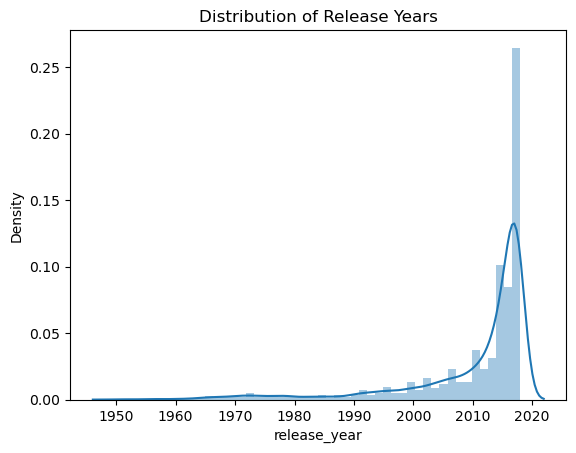

In [34]:
sns.distplot(dff.release_year)
plt.title("Distribution of Release Years");

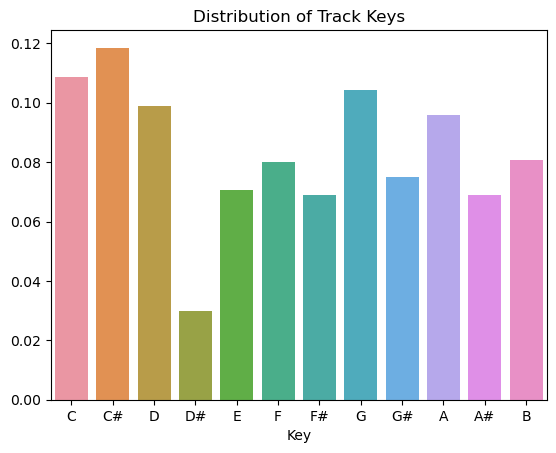

In [35]:
keys = dff.key.value_counts().sort_index()
sns.barplot(
    x = ["C", "C#", "D", "D#", "E", "F", "F#", "G", "G#", "A", "A#", "B"],
    y = keys.values / keys.sum())
plt.title("Distribution of Track Keys")
plt.xlabel("Key");

In [36]:
dff['mode'].value_counts()

dff['mode'].value_counts(normalize=True)

1    32555
0    18149
Name: mode, dtype: int64

1   0.64
0   0.36
Name: mode, dtype: float64

In [37]:
# time_signatures
dff.time_signature.value_counts(normalize=True).sort_index()

0   0.00
1   0.01
3   0.08
4   0.90
5   0.02
Name: time_signature, dtype: float64

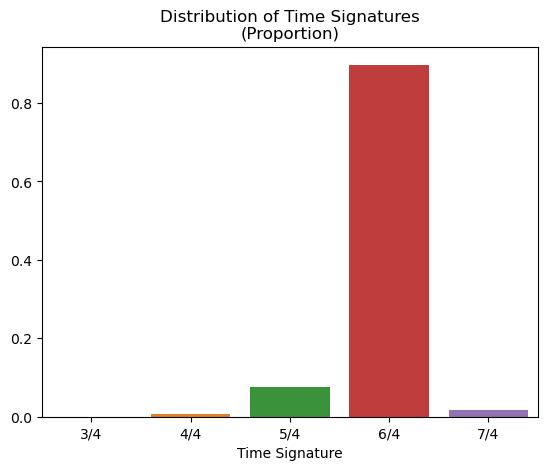

In [38]:
sns.barplot([f"{i}/4" for i in range(3, 8)],
            dff.time_signature.value_counts().sort_index().values /
            dff.time_signature.value_counts().sum())
plt.title("Distribution of Time Signatures\n(Proportion)")
plt.xlabel("Time Signature");

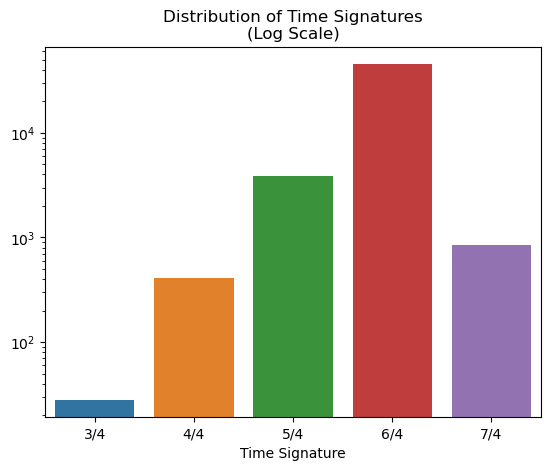

In [39]:
sns.barplot([f"{i}/4" for i in range(3, 8)],
            dff.time_signature.value_counts().sort_index().values)
plt.title("Distribution of Time Signatures\n(Log Scale)")
plt.xlabel("Time Signature")
plt.yscale('log');

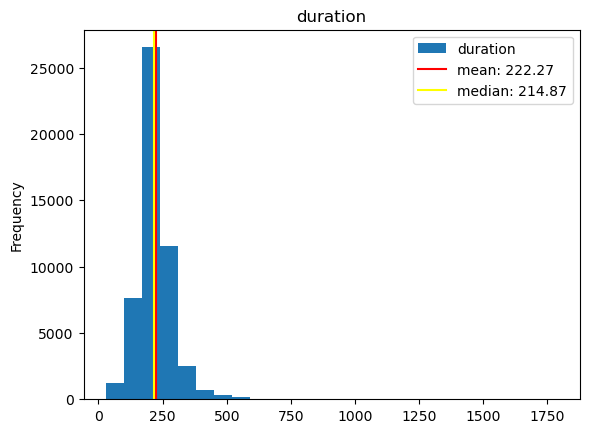

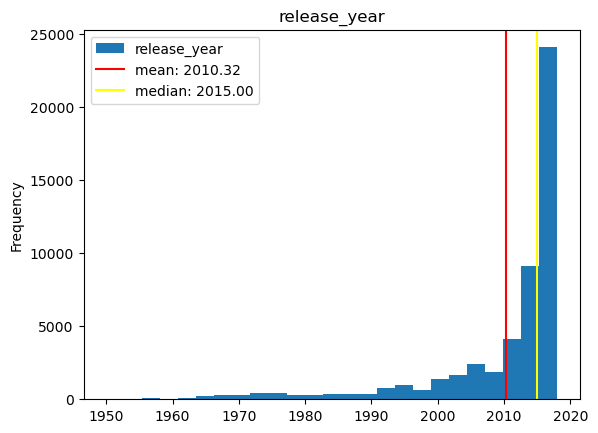

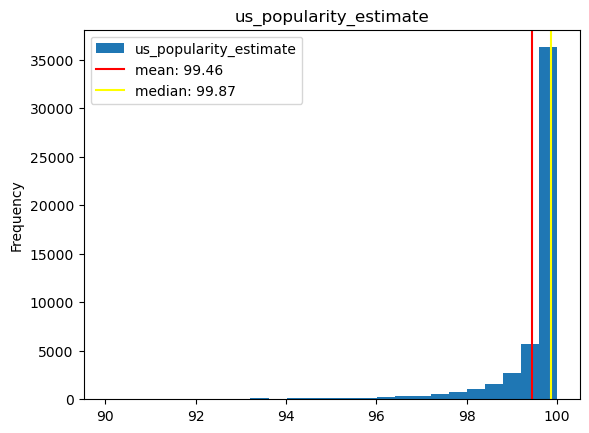

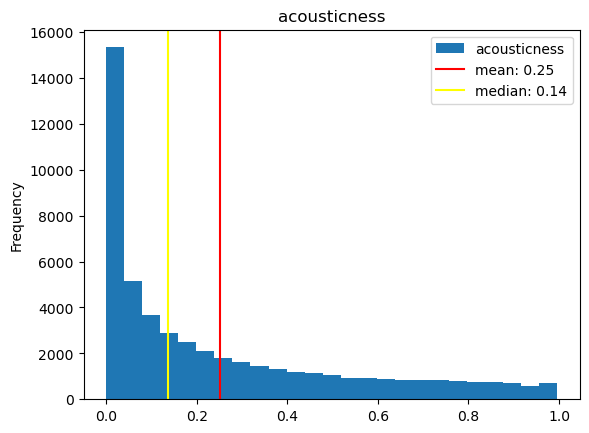

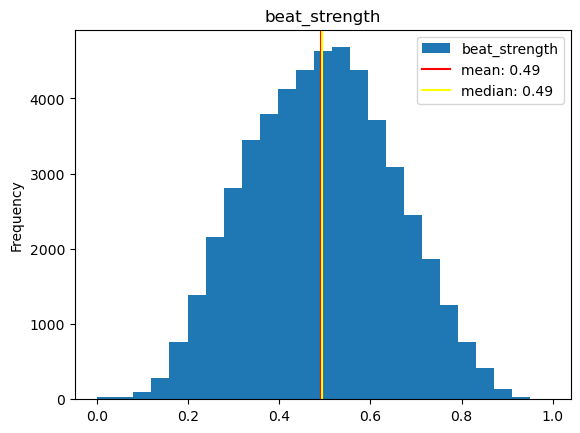

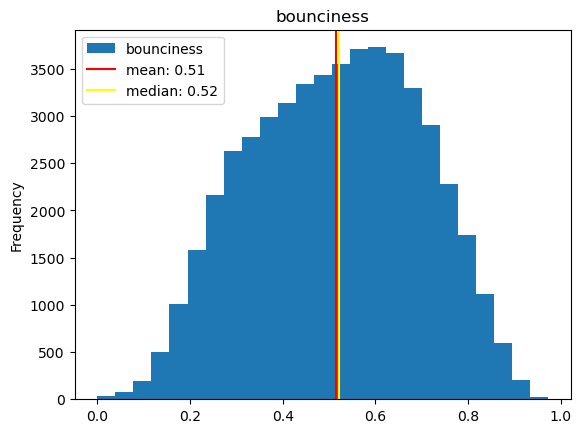

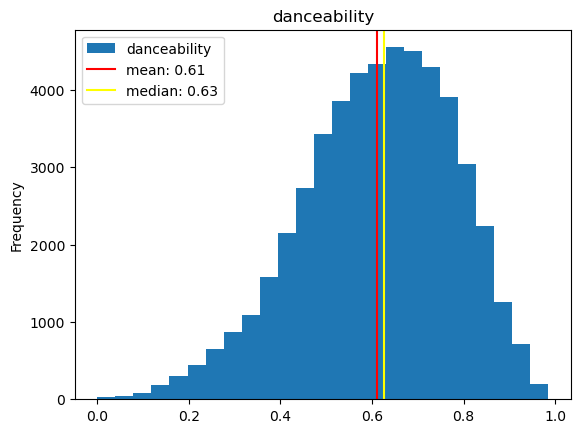

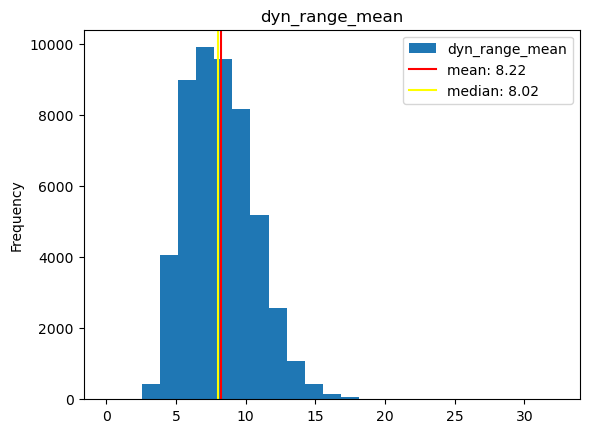

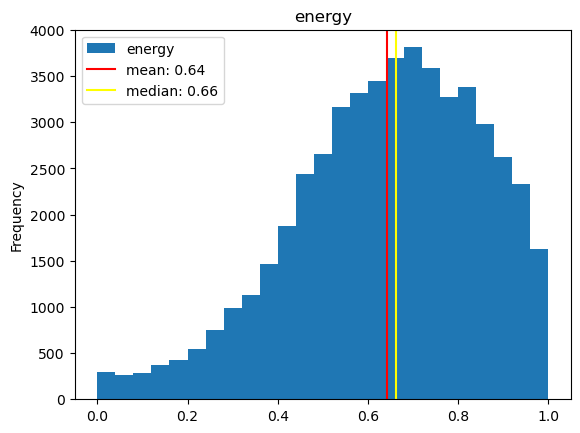

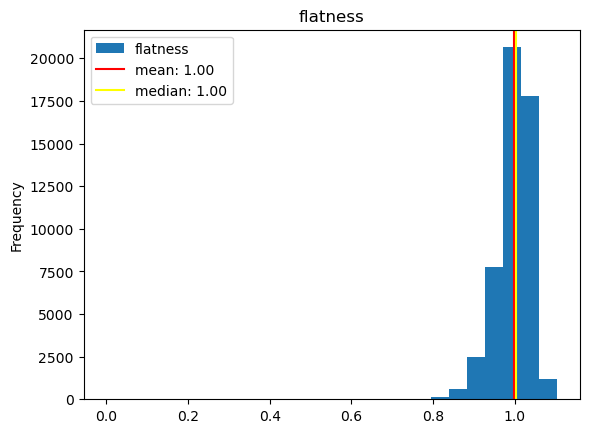

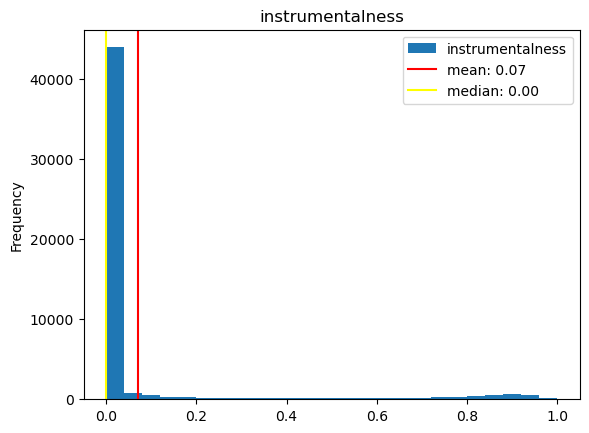

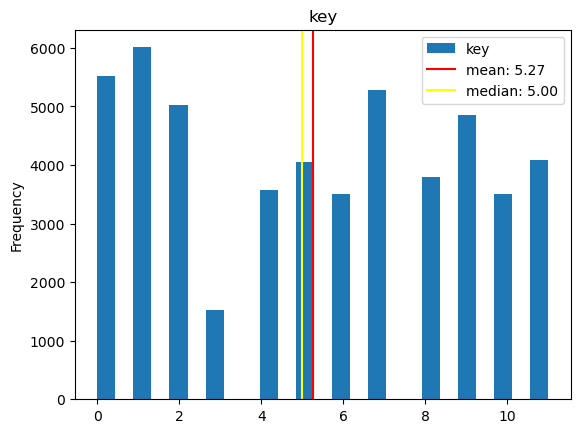

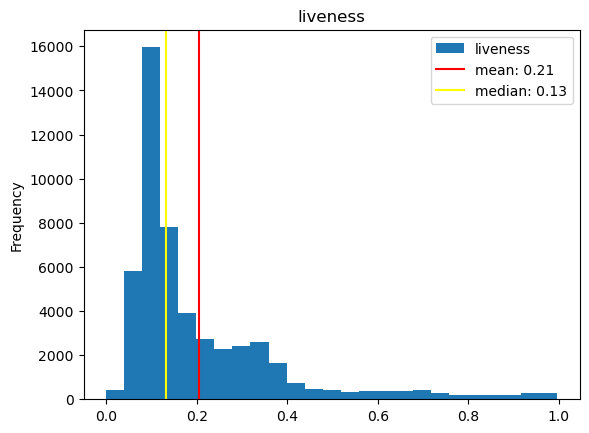

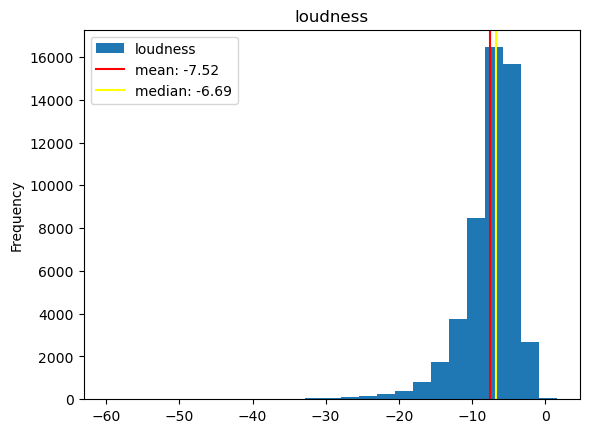

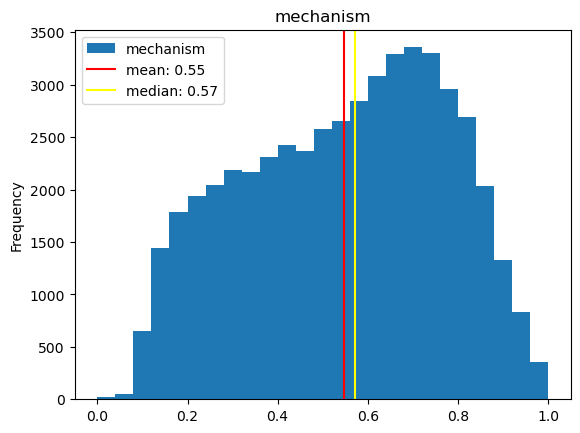

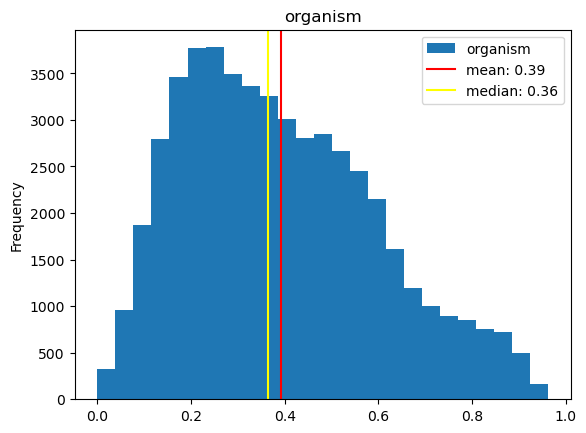

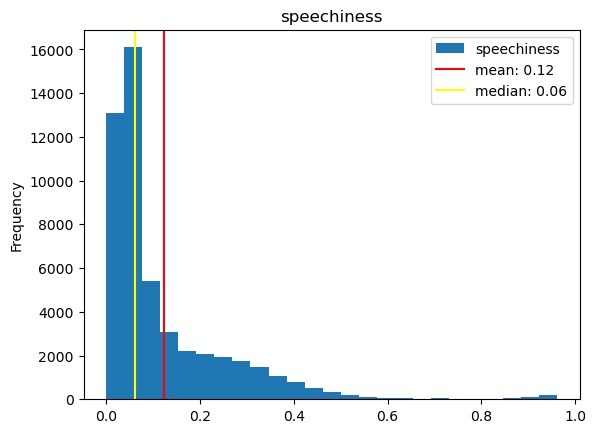

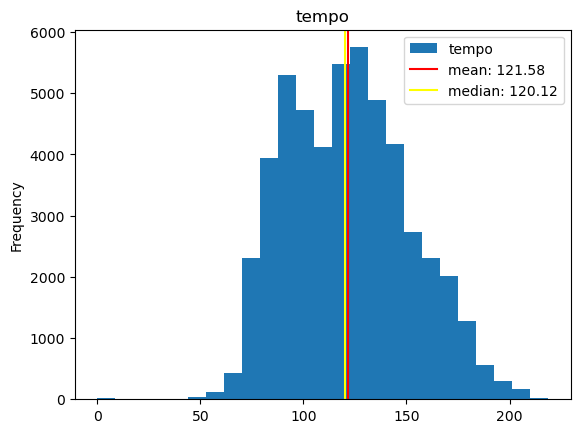

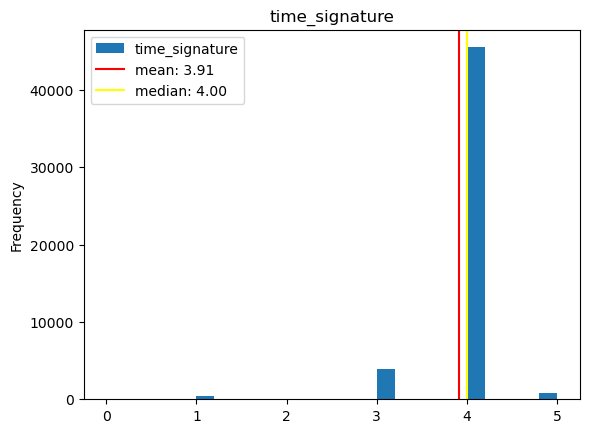

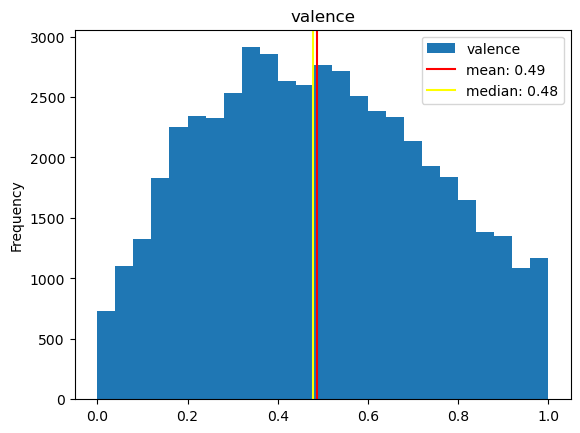

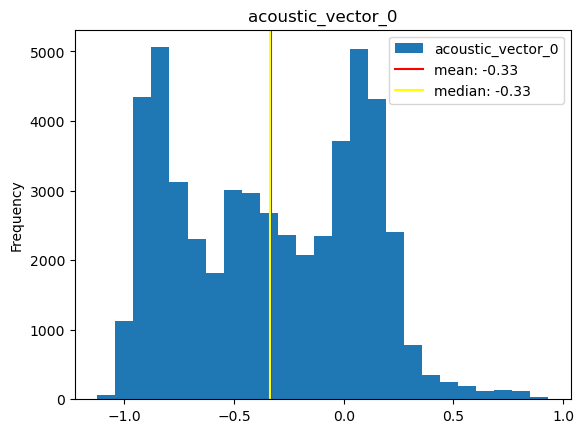

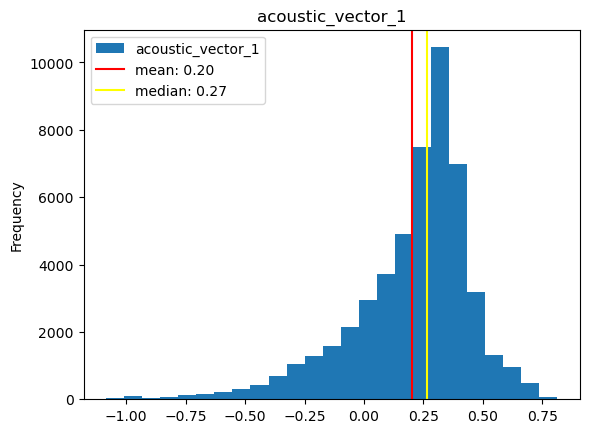

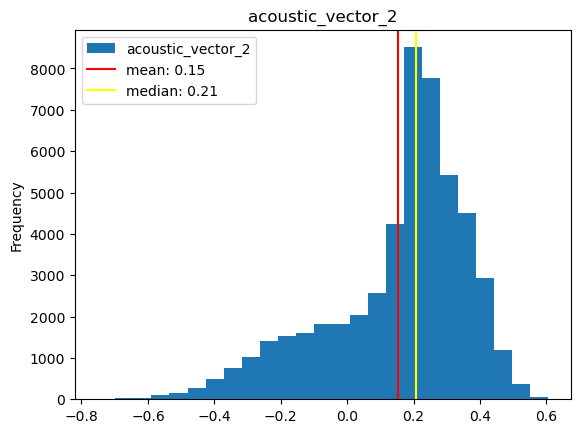

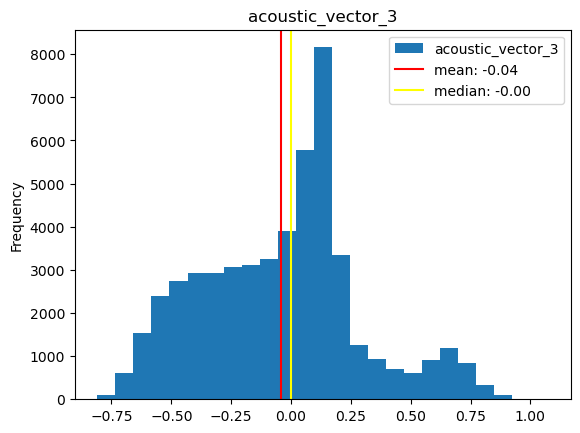

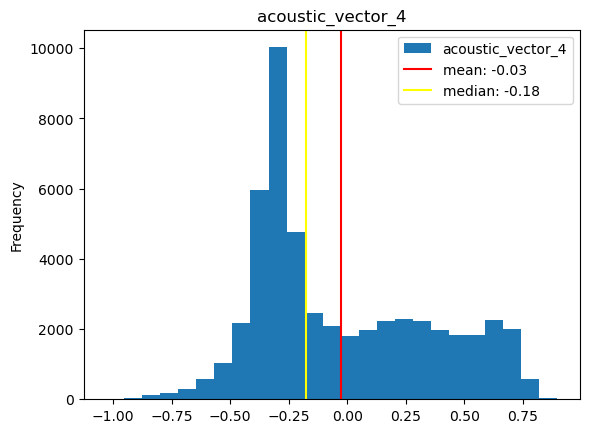

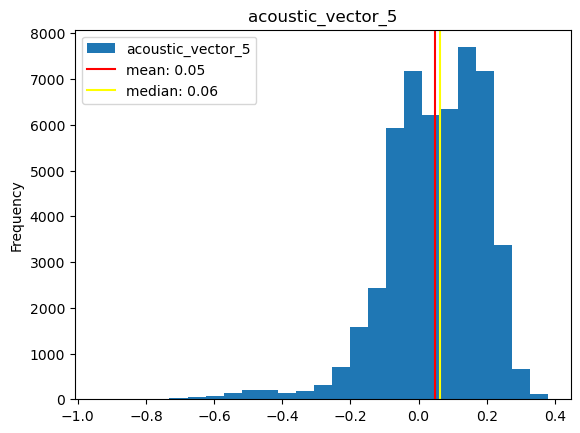

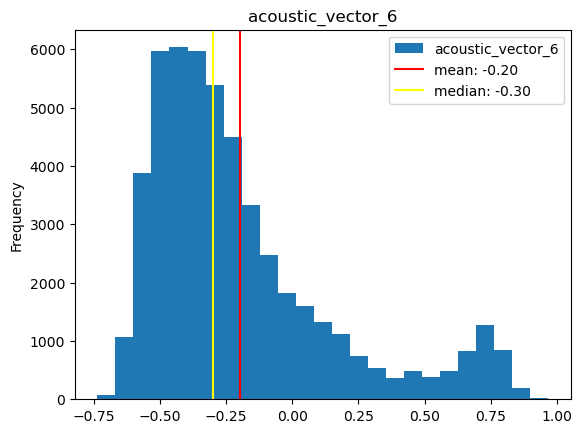

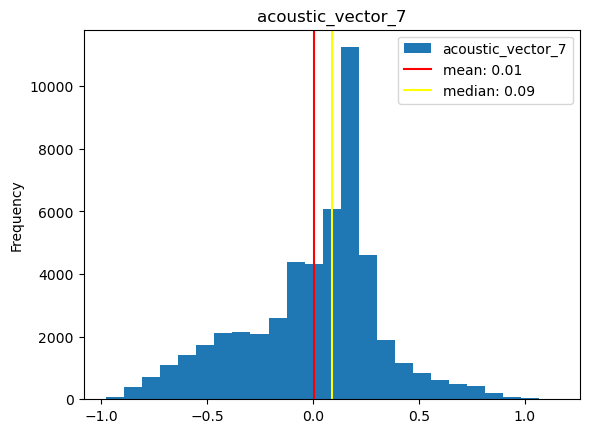

In [40]:
# Plot distribution for each column of track
for col in dff.columns:
    if dff[col].dtype in ['float64', 'int64']:
        plt.figure()
        dff[col].plot.hist(bins=25)
        plt.axvline(dff[col].mean(), color='red', label=f"mean: {dff[col].mean():.2f}")
        plt.axvline(dff[col].median(), color='yellow', label=f"median: {dff[col].median():.2f}")
        plt.legend()
        plt.title(col)
plt.show();

In [41]:
# sns.pairplot(dff);
# plt.savefig("images/track_features_pairplot.png");

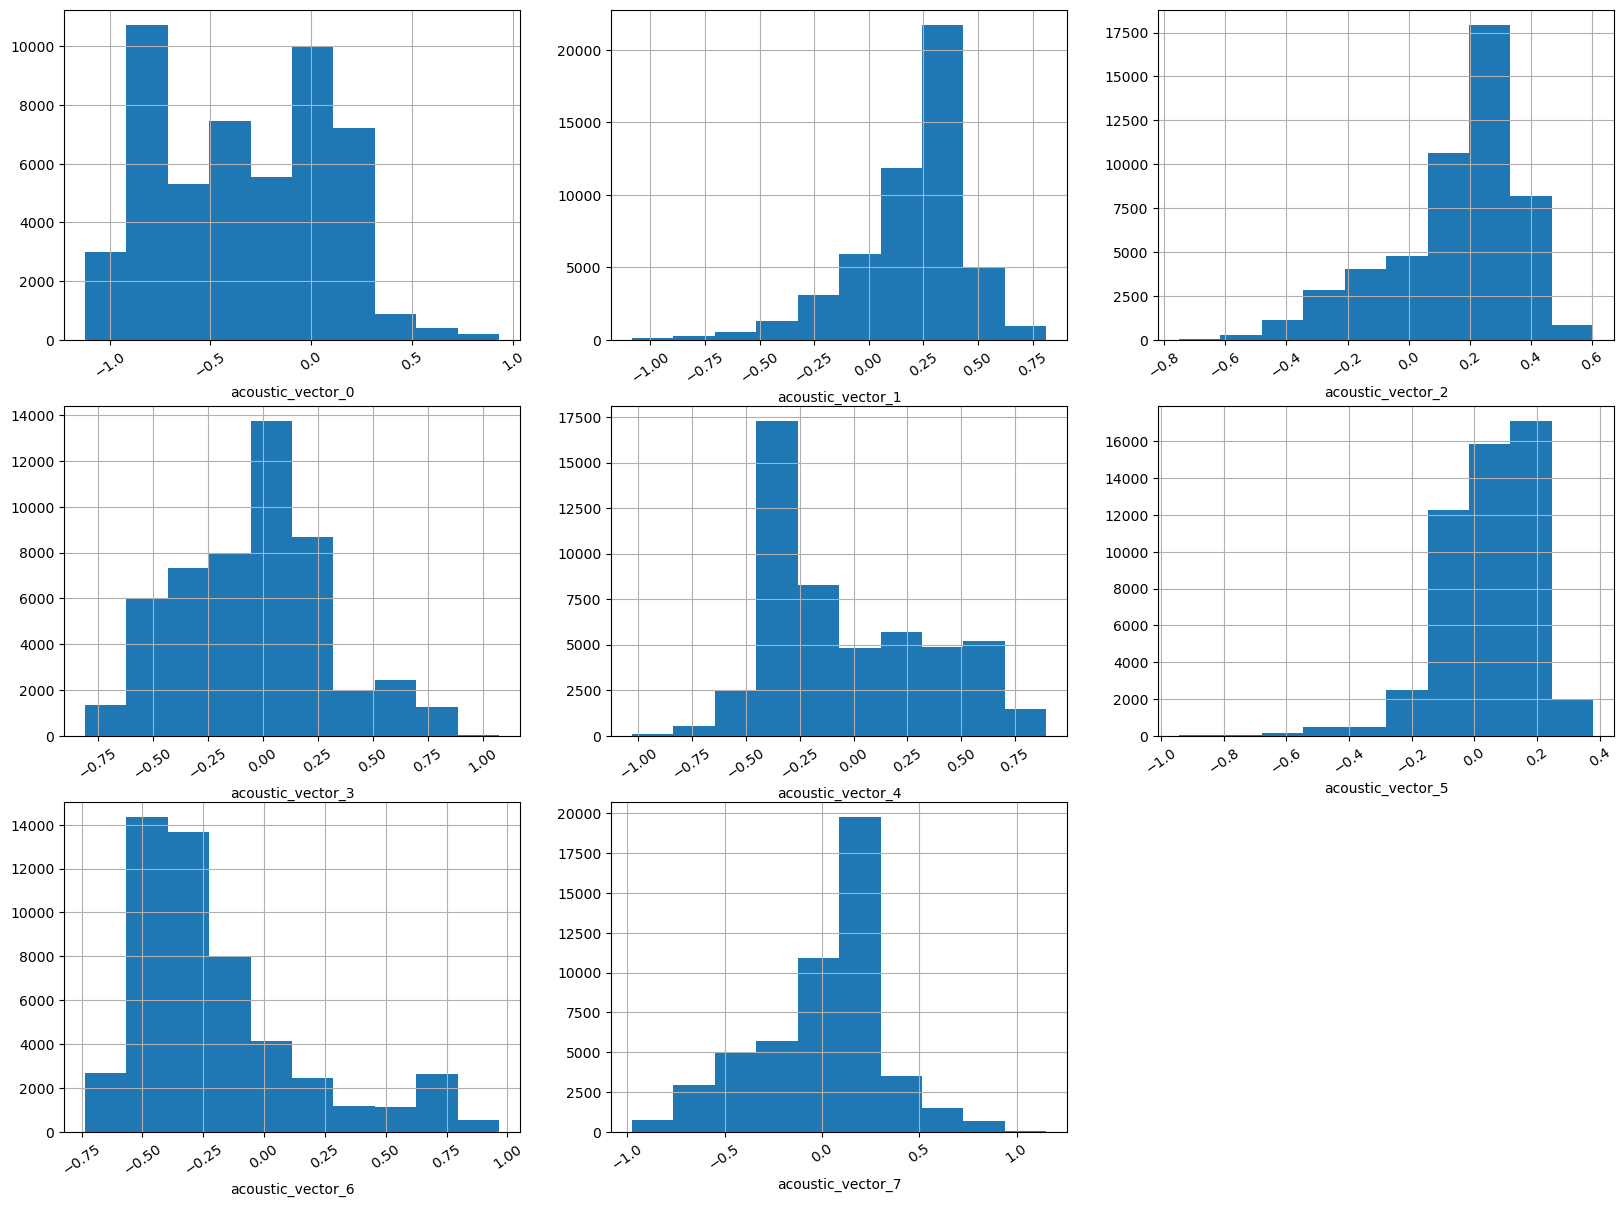

In [42]:
plt.figure(figsize=(20,30))
n = 1

for colname in ['acoustic_vector_0','acoustic_vector_1','acoustic_vector_2',
                'acoustic_vector_3','acoustic_vector_4','acoustic_vector_5',
                'acoustic_vector_6','acoustic_vector_7']:
    plt.subplot(6,3,n)
    dff[colname].hist()
    plt.xlabel(colname)
    plt.xticks(rotation=35)
    n +=1
    
plt.show();

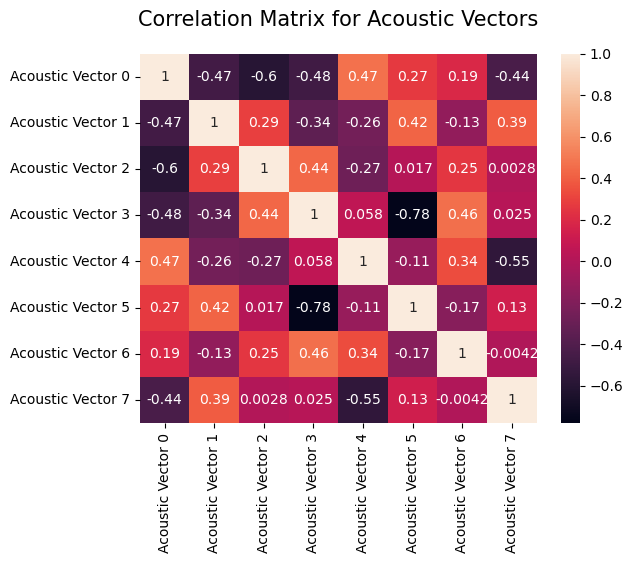

In [43]:
sns.heatmap(dff[[
    "acoustic_vector_0", "acoustic_vector_1", "acoustic_vector_2",
    "acoustic_vector_3", "acoustic_vector_4", "acoustic_vector_5",
    "acoustic_vector_6", "acoustic_vector_7"
]].rename(
    columns={f"acoustic_vector_{i}": f"Acoustic Vector {i}"
             for i in range(8)}).corr(),
            annot=True)
plt.title("Correlation Matrix for Acoustic Vectors", fontsize=15, pad=20);
# plt.savefig("images/acoustic_vector_correlation.png");

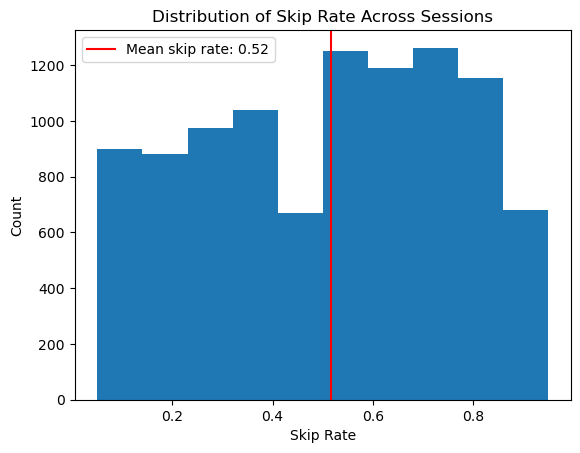

In [44]:
# Plots distribution of skip rate across sessions
plt.figure()
plt.hist(df.groupby('session_id')['skip_2'].mean())
plt.axvline(df['skip_2'].mean(), color='red', label=f"Mean skip rate: {df['skip_2'].mean():.2f}")
plt.title("Distribution of Skip Rate Across Sessions")
plt.legend()
plt.xlabel('Skip Rate')
plt.ylabel('Count')
plt.show();

more sessions with skip rates above 50% than below 50%.
***

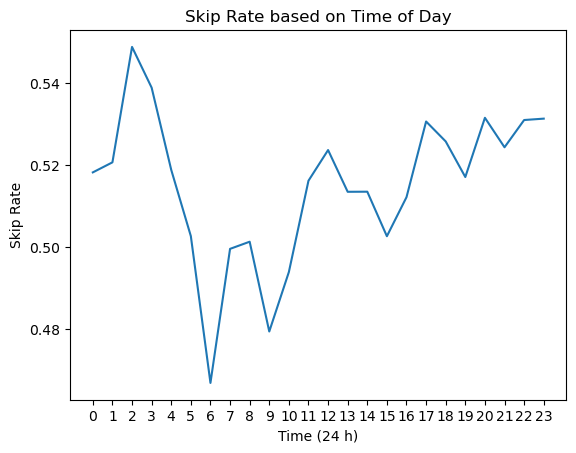

In [45]:
# Plots skip rate vs. time of day
plt.figure()
df.groupby('hour_of_day').mean()['skip_2'].plot()
plt.xticks(range(0,24))
plt.title('Skip Rate based on Time of Day')
plt.xlabel('Time (24 h)')
plt.ylabel('Skip Rate')
plt.show();

Skip rate peaks at 2:00 AM and lowest around 6:00 AM and then again at 9:00 AM. Users might be busy getting ready to start the day. Or might be commuting to work and therefore less likely to skip songs to focus on arriving to their destination safely. 
Skip rate appears to be lowest in the early morning and highest in the afternoon

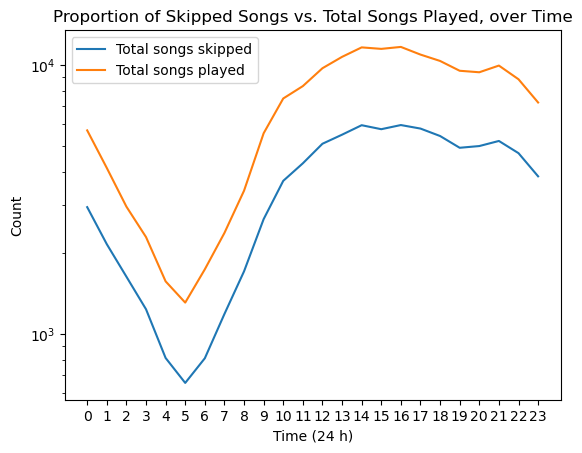

In [46]:
# Plots total songs played in the hour, and the total skips in that hour
plt.figure()
df.groupby('hour_of_day').sum()['skip_2'].plot(label='Total songs skipped')
df['hour_of_day'].value_counts().sort_index().plot(label='Total songs played')
plt.yscale('log')
plt.legend()
plt.xticks(range(0,24))
plt.title('Proportion of Skipped Songs vs. Total Songs Played, over Time')
plt.xlabel('Time (24 h)')
plt.ylabel('Count')
plt.show();

The gap between songs played and songs skipped appears to be constant. So skip rate is nearly constant.
***

In [47]:
# Gets the skip rate across different playlists
round(df.groupby('context_type')['skip_2'].mean().sort_values(ascending=False), 3)

context_type
charts                  0.56
radio                   0.55
user_collection         0.55
editorial_playlist      0.51
catalog                 0.46
personalized_playlist   0.45
Name: skip_2, dtype: float64

In [48]:
# Gets the skip rate for each session based on the grouped by 'context_type'
df1 = df.groupby(['session_id', "context_type"], as_index=False)[['skip_2']].mean()
df1

,session_id,context_type,skip_2
0,0_00006f66-33e5-4de7-a324-2d18e439fc1e,editorial_playlist,0.65
1,0_0000a72b-09ac-412f-b452-9b9e79bded8f,user_collection,0.50
2,0_00010fc5-b79e-4cdf-bc4c-f140d0f99a3a,radio,0.60
3,0_00016a3d-9076-4f67-918f-f29e3ce160dc,radio,0.80
4,0_00018b58-deb8-4f98-ac5e-d7e01b346130,personalized_playlist,0.00
...,...,...,...
12928,0_0eac164c-f209-4590-8608-a56e67658952,user_collection,0.75
12929,0_0eacbee7-9868-48a0-9ab0-f86069329f50,radio,0.85
12930,0_0ead11fc-f32c-4eb4-8fc1-15b51432a404,user_collection,0.60
12931,0_0eae096d-ae4c-4556-8227-0f6294958330,user_collection,0.67


In [49]:
# Gets the frequency of each 'context_type' in the dataframe
df1['context_type'].value_counts()

user_collection          4529
catalog                  3413
editorial_playlist       2552
radio                    2007
personalized_playlist     253
charts                    179
Name: context_type, dtype: int64

In [50]:
# Gets the skip rate based on premium/non-premium status
df.groupby('premium')['skip_2'].mean()

premium
False   0.53
True    0.51
Name: skip_2, dtype: float64

In [51]:
# Gets number of songs played by premium and non-premium users, respectively
df['premium'].value_counts()

True     136053
False     31827
Name: premium, dtype: int64

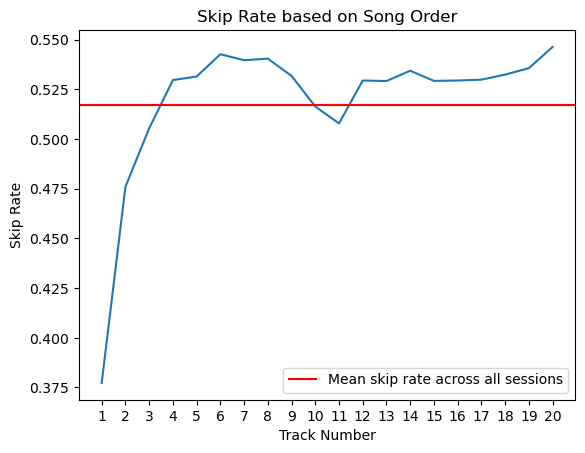

In [52]:
# Plots skip rate across session position
plt.figure()
plt.plot(df.groupby('session_position')['skip_2'].mean())
plt.xticks(range(1,21))
plt.axhline(df['skip_2'].mean(), color='red', label='Mean skip rate across all sessions')
plt.title('Skip Rate based on Song Order')
plt.xlabel('Track Number')
plt.ylabel('Skip Rate')
plt.legend()
plt.show();

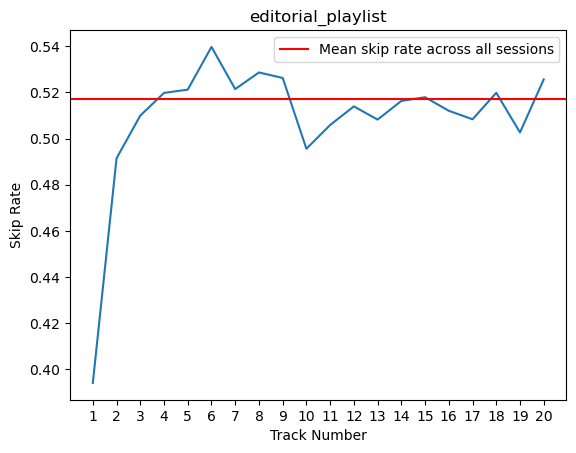

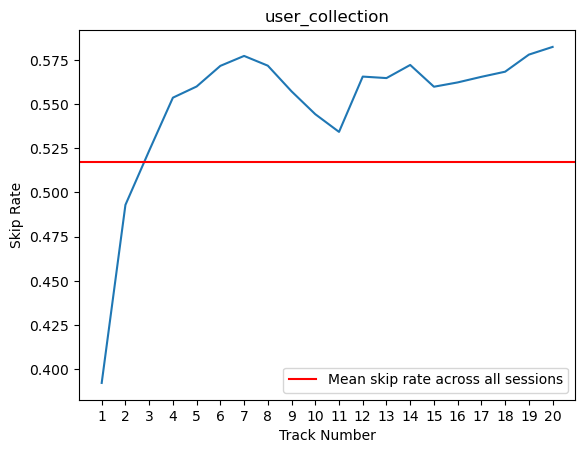

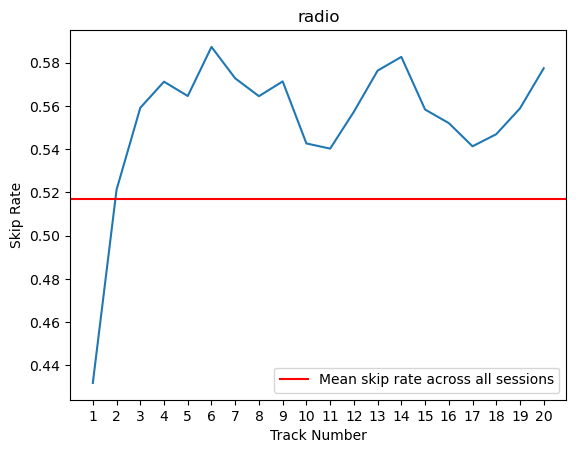

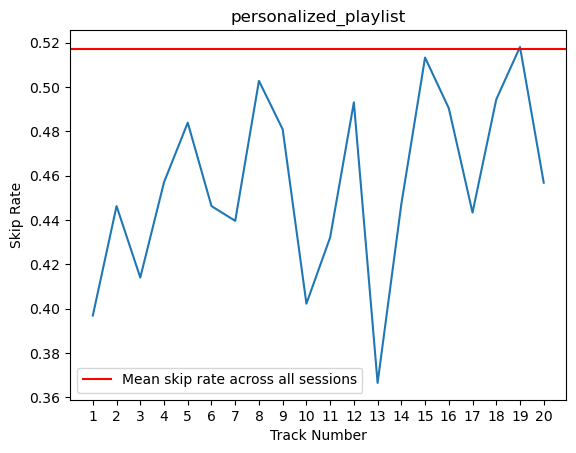

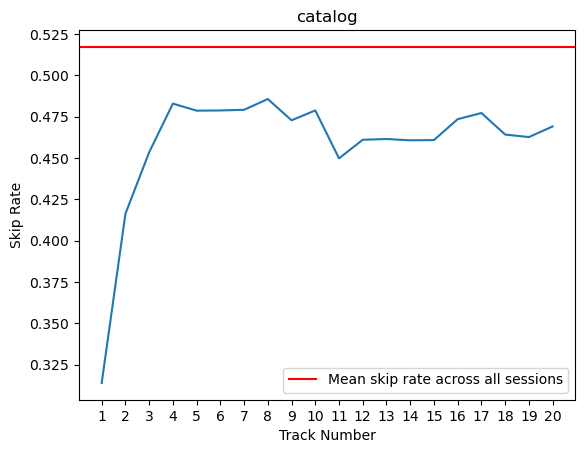

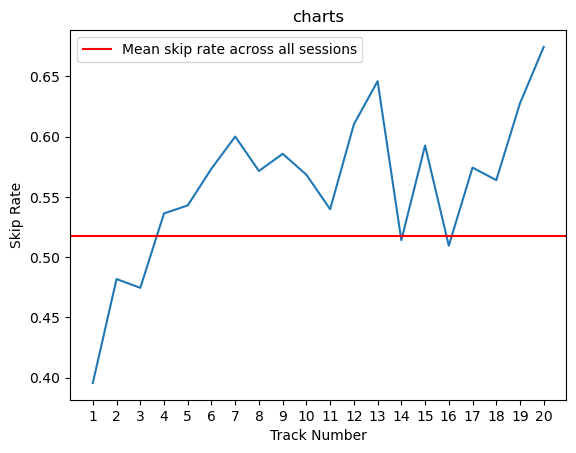

In [53]:
# Gets a list of the different context_types (playlist types)
context_types = ([col for col in df['context_type'].unique()])

# Loops through and plots average skip rate based on track position and 
# context_type
for context in context_types:
    df2 = df[df['context_type'] == context]
    plt.figure()
    plt.plot(df2.groupby('session_position')['skip_2'].mean())
    plt.xticks(range(1,21))
    plt.axhline(df['skip_2'].mean(), color='red', label='Mean skip rate across all sessions')
    plt.title(context)
    plt.xlabel('Track Number')
    plt.ylabel('Skip Rate')
    plt.legend()
plt.show();

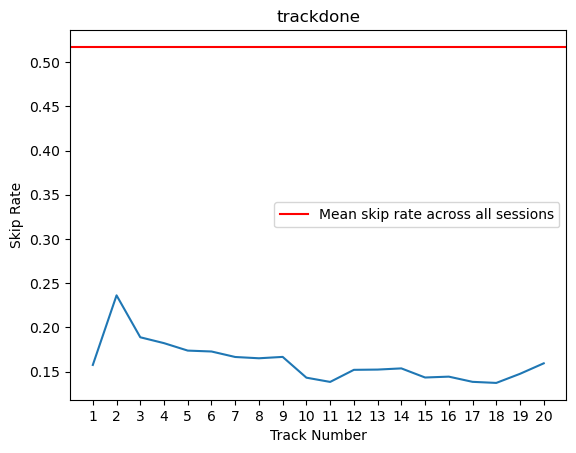

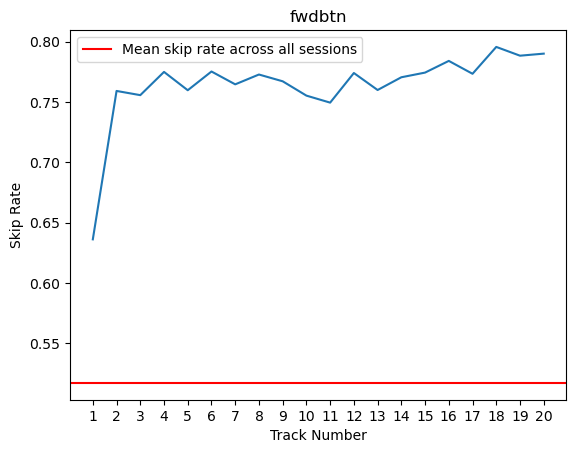

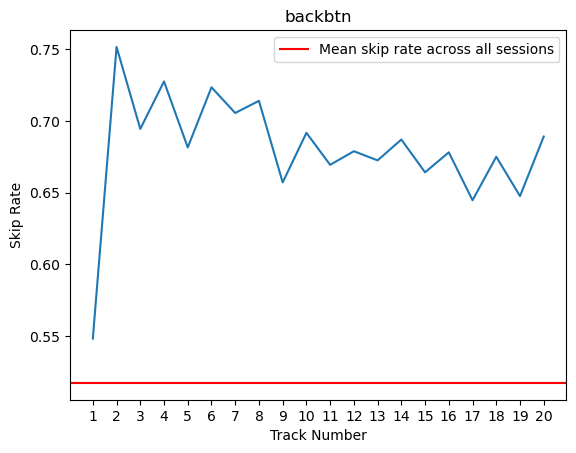

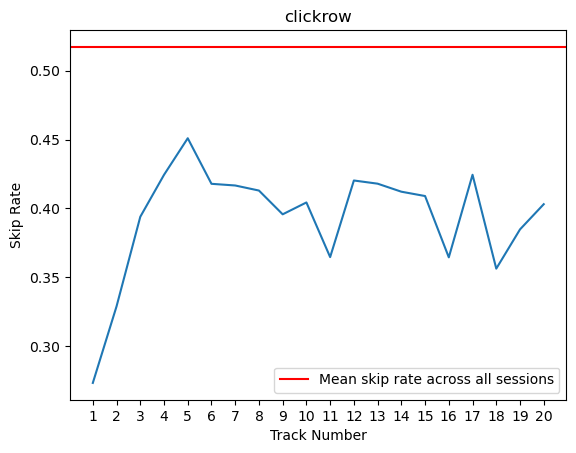

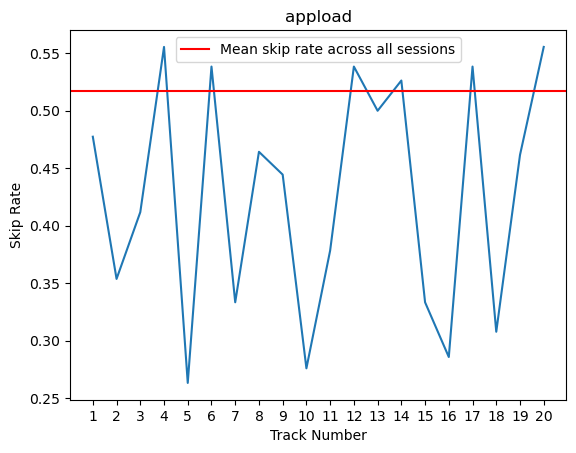

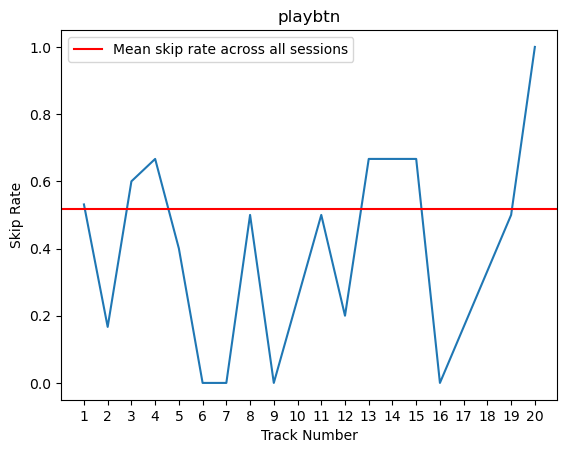

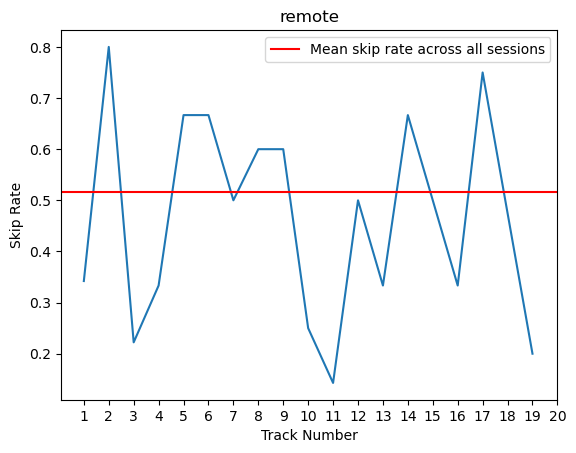

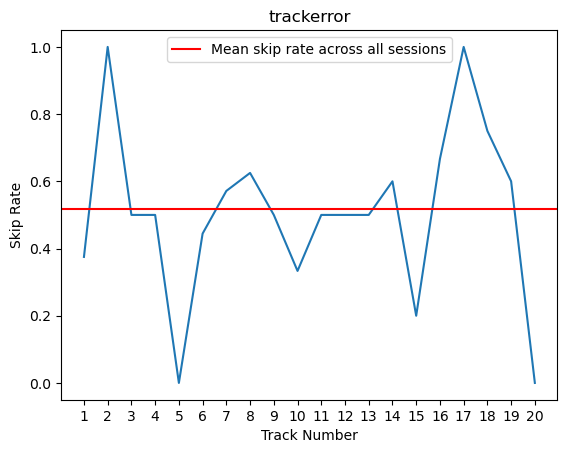

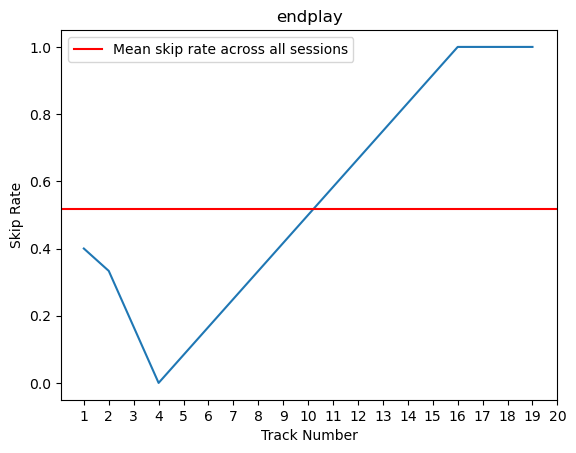

In [54]:
# Gets a list of the different context_types (playlist types)
reason_start_types = ([reason for reason in df['hist_user_behavior_reason_start'].unique()])

# Loops through and plots average skip rate based on track position and 
# context_type
for reason in reason_start_types:
    df3 = df[df['hist_user_behavior_reason_start'] == reason]
    plt.figure()
    plt.plot(df3.groupby('session_position')['skip_2'].mean())
    plt.xticks(range(1,21))
    plt.axhline(df['skip_2'].mean(), color='red', label='Mean skip rate across all sessions')
    plt.title(reason)
    plt.xlabel('Track Number')
    plt.ylabel('Skip Rate')
    plt.legend()
plt.show();

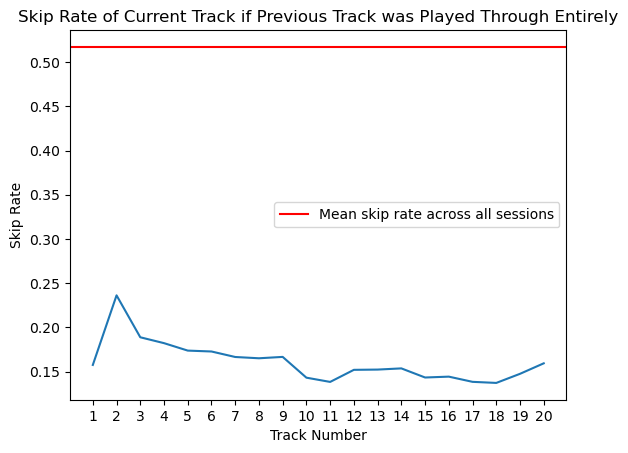

In [55]:
df4 = df[df['hist_user_behavior_reason_start'] == 'trackdone']

plt.figure()
plt.plot(df4.groupby('session_position')['skip_2'].mean())
plt.xticks(range(1,21))
plt.axhline(df['skip_2'].mean(), color='red', label='Mean skip rate across all sessions')
plt.title("Skip Rate of Current Track if Previous Track was Played Through Entirely")
plt.xlabel('Track Number')
plt.ylabel('Skip Rate')
plt.legend()
plt.show();

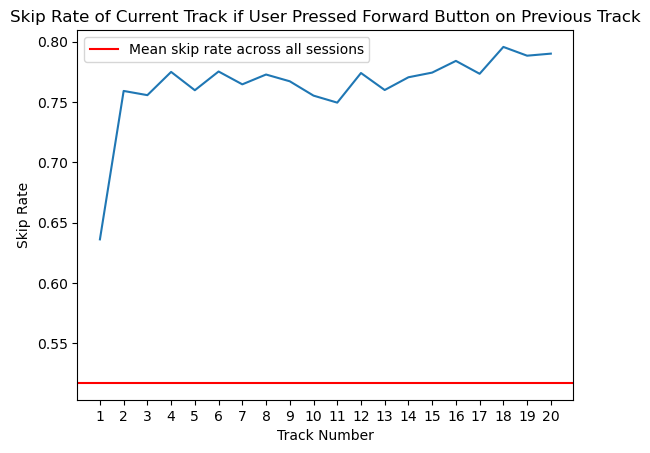

In [56]:
df5 = df[df['hist_user_behavior_reason_start'] == 'fwdbtn']

plt.figure()
plt.plot(df5.groupby('session_position')['skip_2'].mean())
plt.xticks(range(1,21))
plt.axhline(df['skip_2'].mean(), color='red', label='Mean skip rate across all sessions')
plt.title("Skip Rate of Current Track if User Pressed Forward Button on Previous Track")
plt.xlabel('Track Number')
plt.ylabel('Skip Rate')
plt.legend()
plt.show();

<div class="alert alert-block alert-warning">
<b>Inferences:</b> 
    <ul>
        <li>Duration of songs are average 222seconds long. </li>
        <li>Most of songs are more recent. So you want to increase the number of current song because of the traffic . </li>
        <li>Many songs that were played were quite popular. So you want to play both most current and popular songs. </li>
        <li>Most songs appear to be lower on the acousticness scale. </li>
        <li>Fa solfege is most used note. </li>
        <li>The first song of a listening session appears to be skipped less often than other songs in the same session.</li>
        <li>Maybe there ismulti-collinearity in the'beat_strength', 'bounciness' and 'danceability' features. They appear to have similiar distributions. </li>
        <li>52% of songs were skipped(using 'skip_2') </li>
        <li>Skip rate doesn't make much difference between premium and non-premium users </li>
        <li>Skip rate varies depending on the playlist the user is listening to, just like trends in skip rate. Lowest in personalized playlists and highest in chart-type playlists</li>
        <li>On average, the first song in a listening session is skipped less than other songs in a listening session. </li>
     </ul>
</div>

## Merge Data 

In [57]:
main_df = pd.merge(
    df, dff, left_on='track_id_clean', right_on='track_id').sort_values(
        by=['session_id', 'session_position']).reset_index(drop=True)

main_df.sort_values(by=['session_id', 'session_position'], inplace=True)

main_df = main_df.drop(
    columns=['track_id_clean', 'track_id', 'skip_1', 'skip_3', 'not_skipped'],
    axis=1)

In [58]:
main_df.head()
main_df.shape

,session_id,session_position,session_length,skip_2,context_switch,no_pause_before_play,short_pause_before_play,long_pause_before_play,hist_user_behavior_n_seekfwd,hist_user_behavior_n_seekback,hist_user_behavior_is_shuffle,hour_of_day,date,premium,context_type,hist_user_behavior_reason_start,hist_user_behavior_reason_end,duration,release_year,us_popularity_estimate,acousticness,beat_strength,bounciness,danceability,dyn_range_mean,energy,flatness,instrumentalness,key,liveness,loudness,mechanism,mode,organism,speechiness,tempo,time_signature,valence,acoustic_vector_0,acoustic_vector_1,acoustic_vector_2,acoustic_vector_3,acoustic_vector_4,acoustic_vector_5,acoustic_vector_6,acoustic_vector_7
0,0_00006f66-33e5-4de7-a324-2d18e439fc1e,1,20,False,0,0,0,0,0,0,True,16,2018-07-15,True,editorial_playlist,trackdone,trackdone,180.07,2018,99.97,0.02,0.44,0.47,0.65,7.66,0.55,1.04,0.00,1,0.68,-6.58,0.55,1,0.32,0.07,134.02,4,0.15,-0.82,0.39,0.23,0.03,-0.33,0.02,-0.35,0.21
1,0_00006f66-33e5-4de7-a324-2d18e439fc1e,2,20,False,0,1,0,0,0,0,True,16,2018-07-15,True,editorial_playlist,trackdone,trackdone,236.80,2018,99.90,0.06,0.65,0.74,0.88,11.31,0.73,1.03,0.00,7,0.10,-5.32,0.82,0,0.13,0.06,130.04,4,0.34,-0.71,0.36,0.31,-0.04,-0.38,0.07,-0.37,0.16
2,0_00006f66-33e5-4de7-a324-2d18e439fc1e,3,20,False,0,1,0,0,0,0,True,16,2018-07-15,True,editorial_playlist,trackdone,trackdone,231.27,2018,100.00,0.35,0.53,0.54,0.68,8.07,0.56,1.03,0.00,10,0.14,-5.84,0.77,1,0.30,0.05,145.03,4,0.37,-0.74,0.38,0.25,-0.05,-0.30,0.06,-0.49,0.18
3,0_00006f66-33e5-4de7-a324-2d18e439fc1e,4,20,False,0,1,0,0,0,0,True,16,2018-07-15,True,editorial_playlist,trackdone,trackdone,169.83,2018,100.00,0.77,0.64,0.73,0.86,11.29,0.53,0.99,0.00,1,0.10,-7.76,0.63,1,0.60,0.23,111.98,4,0.65,-0.71,0.32,0.29,-0.04,-0.39,0.09,-0.36,0.29
4,0_00006f66-33e5-4de7-a324-2d18e439fc1e,5,20,False,0,1,0,0,0,0,True,16,2018-07-15,True,editorial_playlist,trackdone,trackdone,210.55,2018,100.00,0.01,0.73,0.79,0.86,12.18,0.65,1.00,0.00,8,0.12,-4.92,0.76,1,0.17,0.24,147.03,4,0.65,-0.87,0.33,0.21,0.08,-0.33,-0.03,-0.51,0.18


(167880, 46)

In [59]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 167880 entries, 0 to 167879
Data columns (total 46 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   session_id                       167880 non-null  object 
 1   session_position                 167880 non-null  int64  
 2   session_length                   167880 non-null  int64  
 3   skip_2                           167880 non-null  bool   
 4   context_switch                   167880 non-null  int64  
 5   no_pause_before_play             167880 non-null  int64  
 6   short_pause_before_play          167880 non-null  int64  
 7   long_pause_before_play           167880 non-null  int64  
 8   hist_user_behavior_n_seekfwd     167880 non-null  int64  
 9   hist_user_behavior_n_seekback    167880 non-null  int64  
 10  hist_user_behavior_is_shuffle    167880 non-null  bool   
 11  hour_of_day                      167880 non-null  int64  
 12  da

In [60]:
profile_main_df = ProfileReport(main_df, title="Main DF Report")

profile_main_df.to_file("main_df_report.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [61]:
main_df.to_pickle('merged.pkl', compression='gzip')